After the smiles text representation for molecules, let us now look at the graph representation for molecules. The graph representation is the most natural representation of molecules. A graph normally can be representated by a set of nodes and edges. For molecules, the nodes are the atoms and edges are the bonds. The topological information is naturally representated by the graph. A good example of the molecular graph is shown in the figure below:
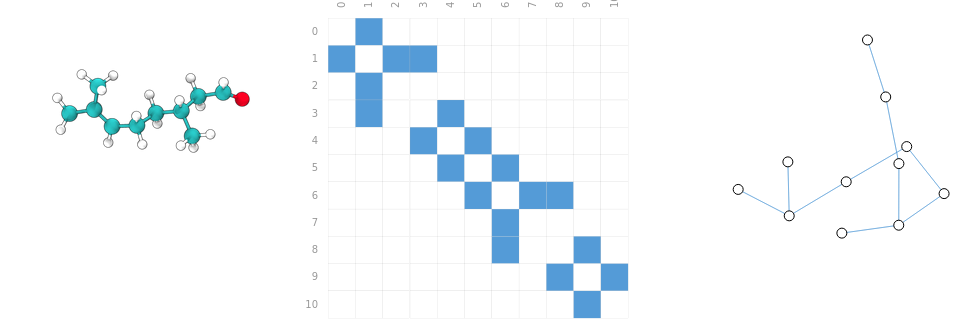
This figure is adopted from the GNN tutorial:https://distill.pub/2021/gnn-intro/

Although when we draw the molecule in terms of a graph, when we represent a graph in computer language we used normally three matrix to represent it. The first matrix is the adjacent matrix as shown in the middle of the above figure. It shows how the atoms are linking with each other. The second matrix will be the feature matrix of atoms. For each atom, the simplest way is to use a vector to represent it. And similarly there will be a bond matrix. The details are discussed in the paper:"Crystals vs Molecules: Representation, Prediction and Inverse Design." Let us dive into the details of code implementation to understand how people use this representation in ML applicaitons. I will show the implementation of the featurization of graphs of molecules from several popular studies:1. DeepChem, 2. Chemprop

Below will be the DeepChem implementation. For deepchem implementation, several useful functions and the graph class will be firstly constructed. The basic logics are to build functions that can retrive the useful features of atoms and bonds easily. In addition can transform them into machine easy to process forms such as one hot encoding. It is because the feature needs to be a float for the model after words to process. Models normally don't directly use strings.

The following three blocks contain the utility functions for the construction of molecular graph features in deepchem. One of the most frequently used function is the one_hot_encoding function, please understand it and maybe remember it. Then the functions are used to get the feature information for the nodes(atoms) or the edges(bonds) to construct the node feature matrix and edge feature matrix. The topology are recorded in an adjacent matrix or in a COO format depends on the real implementation of different featurizers. In addition, some of the featurizer try to include the distance matrix as additional information. For the methods described, the distance can be either a topological distance (i.e., meaning how many bonds a node need to walk to get to another node) or a real distance matrix calculated by the coordinates distance between nodes.

In [2]:
from typing import List, Tuple, Any, Optional, Sequence, Dict
import numpy as np
'''
This is the graph data class used by deepchem
'''


class GraphData:
  """GraphData class
  This data class is almost same as `torch_geometric.data.Data
  <https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data>`_.
  Attributes
  ----------
  node_features: np.ndarray
    Node feature matrix with shape [num_nodes, num_node_features]
    This is the atom's feature matrix, in this form, each row represent the feature
    of an atom as said before.
  edge_index: np.ndarray, dtype int
    Graph connectivity in COO format with shape [2, num_edges]
    COO is the coordinate format, here only stores the connectivity thus, there is only two rows.
    If data is stored then normally will be 3 rows. 
    
    To better understand, it is actually the same function as the adjacent matrix, but it is more
    space efficient way to store the connectivity information.
    
  edge_features: np.ndarray, optional (default None)
    Edge feature matrix with shape [num_edges, num_edge_features]
    This is the bond's feature matrix, each row represent the feature of a bond.
  node_pos_features: np.ndarray, optional (default None)
    Node position matrix with shape [num_nodes, num_dimensions].
    This is only useful when we have the specific postion of atoms in the space. This may can be
    calculated by compute 2D or 3D coordinates. 
  num_nodes: int
    The number of nodes in the graph
  num_node_features: int
    The number of features per node in the graph.
    Actually this is the dimension of node's features. If the element is representated by
    one hot vectors, then definitely the number of node features will be large.
  num_edges: int
    The number of edges in the graph
  num_edges_features: int, optional (default None)
    The number of features per edge in the graph
  Examples
  --------
  >>> import numpy as np
  >>> node_features = np.random.rand(5, 10)
  >>> edge_index = np.array([[0, 1, 2, 3, 4], [1, 2, 3, 4, 0]], dtype=np.int64)
  >>> edge_features = np.random.rand(5, 5)
  >>> global_features = np.random.random(5)
  the global features should be seldom used.
  >>> graph = GraphData(node_features, edge_index, edge_features, z=global_features)
  >>> graph
  GraphData(node_features=[5, 10], edge_index=[2, 5], edge_features=[5, 5], z=[5])
  """

  def __init__(self,
               node_features: np.ndarray,
               edge_index: np.ndarray,
               edge_features: Optional[np.ndarray] = None,
               node_pos_features: Optional[np.ndarray] = None,
               **kwargs):
    """
    Parameters
    ----------
    node_features: np.ndarray
      Node feature matrix with shape [num_nodes, num_node_features]
    edge_index: np.ndarray, dtype int
      Graph connectivity in COO format with shape [2, num_edges]
    edge_features: np.ndarray, optional (default None)
      Edge feature matrix with shape [num_edges, num_edge_features]
    node_pos_features: np.ndarray, optional (default None)
      Node position matrix with shape [num_nodes, num_dimensions].
    kwargs: optional
      Additional attributes and their values
    """

    '''
    All the below terms are to help users to use this class and guide them to input the correct
    form of data, this object is mainly based on numpy array data structure.
    '''
    # validate params
    if isinstance(node_features, np.ndarray) is False:
      raise ValueError('node_features must be np.ndarray.')

    if isinstance(edge_index, np.ndarray) is False:
      raise ValueError('edge_index must be np.ndarray.')
    elif issubclass(edge_index.dtype.type, np.integer) is False:
      raise ValueError('edge_index.dtype must contains integers.')
    elif edge_index.shape[0] != 2:
      raise ValueError('The shape of edge_index is [2, num_edges].')
    elif np.max(edge_index) >= len(node_features):
      raise ValueError('edge_index contains the invalid node number.')

    if edge_features is not None:
      if isinstance(edge_features, np.ndarray) is False:
        raise ValueError('edge_features must be np.ndarray or None.')
      elif edge_index.shape[1] != edge_features.shape[0]:
        raise ValueError('The first dimension of edge_features must be the \
                          same as the second dimension of edge_index.')

    if node_pos_features is not None:
      if isinstance(node_pos_features, np.ndarray) is False:
        raise ValueError('node_pos_features must be np.ndarray or None.')
      elif node_pos_features.shape[0] != node_features.shape[0]:
        raise ValueError(
            'The length of node_pos_features must be the same as the \
                          length of node_features.')

    self.node_features = node_features
    self.edge_index = edge_index
    self.edge_features = edge_features
    self.node_pos_features = node_pos_features
    self.kwargs = kwargs
    self.num_nodes, self.num_node_features = self.node_features.shape
    self.num_edges = edge_index.shape[1]
    if self.edge_features is not None:
      self.num_edge_features = self.edge_features.shape[1]

    for key, value in self.kwargs.items():
      setattr(self, key, value)

  def __repr__(self) -> str:
    """Returns a string containing the printable representation of the object"""
    cls = self.__class__.__name__
    node_features_str = str(list(self.node_features.shape))
    edge_index_str = str(list(self.edge_index.shape))
    if self.edge_features is not None:
      edge_features_str = str(list(self.edge_features.shape))
    else:
      edge_features_str = None

    out = "%s(node_features=%s, edge_index=%s, edge_features=%s" % (
        cls, node_features_str, edge_index_str, edge_features_str)
    # Adding shapes of kwargs
    for key, value in self.kwargs.items():
      out += (', ' + key + '=' + str(list(value.shape)))
    out += ')'
    return out

  def to_pyg_graph(self):
    '''
    Not important yet, later will tell the detail.
    '''

    """Convert to PyTorch Geometric graph data instance
    Returns
    -------
    torch_geometric.data.Data
      Graph data for PyTorch Geometric
    Note
    ----
    This method requires PyTorch Geometric to be installed.
    """
    try:
      import torch
      from torch_geometric.data import Data
    except ModuleNotFoundError:
      raise ImportError(
          "This function requires PyTorch Geometric to be installed.")

    edge_features = self.edge_features
    if edge_features is not None:
      edge_features = torch.from_numpy(self.edge_features).float()
    node_pos_features = self.node_pos_features
    if node_pos_features is not None:
      node_pos_features = torch.from_numpy(self.node_pos_features).float()
    kwargs = {}
    for key, value in self.kwargs.items():
      kwargs[key] = torch.from_numpy(value).float()
    return Data(
        x=torch.from_numpy(self.node_features).float(),
        edge_index=torch.from_numpy(self.edge_index).long(),
        edge_attr=edge_features,
        pos=node_pos_features,
        **kwargs)

  def to_dgl_graph(self, self_loop: bool = False):
    '''
    Not important yet, later will tell the detail.
    '''
    """Convert to DGL graph data instance
    Returns
    -------
    dgl.DGLGraph
      Graph data for DGL
    self_loop: bool
      Whether to add self loops for the nodes, i.e. edges from nodes
      to themselves. Default to False.
    Note
    ----
    This method requires DGL to be installed.
    """
    try:
      import dgl
      import torch
    except ModuleNotFoundError:
      raise ImportError("This function requires DGL to be installed.")

    src = self.edge_index[0]
    dst = self.edge_index[1]

    g = dgl.graph(
        (torch.from_numpy(src).long(), torch.from_numpy(dst).long()),
        num_nodes=self.num_nodes)
    g.ndata['x'] = torch.from_numpy(self.node_features).float()

    if self.node_pos_features is not None:
      g.ndata['pos'] = torch.from_numpy(self.node_pos_features).float()

    if self.edge_features is not None:
      g.edata['edge_attr'] = torch.from_numpy(self.edge_features).float()

    if self_loop:
      # This assumes that the edge features for self loops are full-zero tensors
      # In the future we may want to support featurization for self loops
      g.add_edges(np.arange(self.num_nodes), np.arange(self.num_nodes))

    return g


class BatchGraphData(GraphData):
  """Batch GraphData class
  Attributes
  ----------
  node_features: np.ndarray
    Instead of creating a tensor with 3 dimensions like [num_of_graphs_in_batch, num_nodes, num_node_features]
    It just concate all graphs in a batch. Since the size of the graphs may not be the same, then
    the total number of nodes can not be simply calculated as num_of_graphs_in_batch X num_nodes
    Concatenated node feature matrix with shape [num_nodes, num_node_features].
    `num_nodes` is total number of nodes in the batch graph.
  edge_index: np.ndarray, dtype int
    Concatenated graph connectivity in COO format with shape [2, num_edges].
    `num_edges` is total number of edges in the batch graph.
  edge_features: np.ndarray, optional (default None)
    Concatenated edge feature matrix with shape [num_edges, num_edge_features].
    `num_edges` is total number of edges in the batch graph.
  node_pos_features: np.ndarray, optional (default None)
    Concatenated node position matrix with shape [num_nodes, num_dimensions].
    `num_nodes` is total number of edges in the batch graph.
  num_nodes: int
    The number of nodes in the batch graph.
  num_node_features: int
    The number of features per node in the graph.
  num_edges: int
    The number of edges in the batch graph.
  num_edges_features: int, optional (default None)
    The number of features per edge in the graph.
  graph_index: np.ndarray, dtype int
    This vector indicates which graph the node belongs with shape [num_nodes,].
    This is very important information to track the graphs
  Examples
  --------
  >>> import numpy as np
  >>> from deepchem.feat.graph_data import GraphData
  >>> node_features_list = np.random.rand(2, 5, 10)
  >>> edge_index_list = np.array([
  ...    [[0, 1, 2, 3, 4], [1, 2, 3, 4, 0]],
  ...    [[0, 1, 2, 3, 4], [1, 2, 3, 4, 0]],
  ... ], dtype=int)
  >>> graph_list = [GraphData(node_features, edge_index) for node_features, edge_index
  ...           in zip(node_features_list, edge_index_list)]
  >>> batch_graph = BatchGraphData(graph_list=graph_list)
  """

  def __init__(self, graph_list: Sequence[GraphData]):
    """
    Parameters
    ----------
    graph_list: Sequence[GraphData]
      List of GraphData
    """
    # stack features
    # It will concate the node features, concate the matrix.
    '''
    vstack concate along the first axis
    a = np.array([1, 2, 3])

    b = np.array([4, 5, 6])
    
    np.vstack((a,b))
    array([[1, 2, 3],
          [4, 5, 6]])
    
    '''
    batch_node_features = np.vstack(
        [graph.node_features for graph in graph_list])

    # before stacking edge_features or node_pos_features,
    # we should check whether these are None or not
    if graph_list[0].edge_features is not None:
      batch_edge_features: Optional[np.ndarray] = np.vstack(
          [graph.edge_features for graph in graph_list])  # type: ignore
    else:
      batch_edge_features = None

    if graph_list[0].node_pos_features is not None:
      batch_node_pos_features: Optional[np.ndarray] = np.vstack(
          [graph.node_pos_features for graph in graph_list])  # type: ignore
    else:
      batch_node_pos_features = None

    # create new edge index
    num_nodes_list = [graph.num_nodes for graph in graph_list]
    '''
    hstack concate along the second axis,
    num_node_list is a list,[0, first_graph_number_node, second_graph_num_node,....]
    It will add up the number of nodes in the previous graph to the current graph node's index
    to combine the graphs and record their connectivities in on matrix.
    '''
    batch_edge_index = np.hstack([
        graph.edge_index + prev_num_node
        for prev_num_node, graph in zip([0] + num_nodes_list[:-1], graph_list)
    ])

    # graph_index indicates which nodes belong to which graph
    graph_index = []
    '''
    It will be like [1,1,1,1,2,2,3,3.....]
    '''
    for i, num_nodes in enumerate(num_nodes_list):
      graph_index.extend([i] * num_nodes)
    self.graph_index = np.array(graph_index)

    super().__init__(
        node_features=batch_node_features,
        edge_index=batch_edge_index,
        edge_features=batch_edge_features,
        node_pos_features=batch_node_pos_features,
    )


In [3]:
"""
Utilities for constructing node features or bond features.
Some functions are based on chainer-chemistry or dgl-lifesci.
Repositories:
- https://github.com/chainer/chainer-chemistry
- https://github.com/awslabs/dgl-lifesci
"""

import os
import logging
from typing import List, Union, Tuple, Any

import numpy as np


logger = logging.getLogger(__name__)

DEFAULT_ATOM_TYPE_SET = [
    "C",
    "N",
    "O",
    "F",
    "P",
    "S",
    "Cl",
    "Br",
    "I",
]
DEFAULT_HYBRIDIZATION_SET = ["SP", "SP2", "SP3"]
DEFAULT_TOTAL_NUM_Hs_SET = [0, 1, 2, 3, 4]
DEFAULT_FORMAL_CHARGE_SET = [-2, -1, 0, 1, 2]
DEFAULT_TOTAL_DEGREE_SET = [0, 1, 2, 3, 4, 5]
DEFAULT_RING_SIZE_SET = [3, 4, 5, 6, 7, 8]
DEFAULT_BOND_TYPE_SET = ["SINGLE", "DOUBLE", "TRIPLE", "AROMATIC"]
DEFAULT_BOND_STEREO_SET = ["STEREONONE", "STEREOANY", "STEREOZ", "STEREOE"]
DEFAULT_GRAPH_DISTANCE_SET = [1, 2, 3, 4, 5, 6, 7]
DEFAULT_ATOM_IMPLICIT_VALENCE_SET = [0, 1, 2, 3, 4, 5, 6]
DEFAULT_ATOM_EXPLICIT_VALENCE_SET = [1, 2, 3, 4, 5, 6]


class _ChemicalFeaturesFactory:
  """This is a singleton class for RDKit base features."""
  _instance = None

  @classmethod
  def get_instance(cls):
    try:
      from rdkit import RDConfig
      from rdkit.Chem import ChemicalFeatures
    except ModuleNotFoundError:
      raise ImportError("This class requires RDKit to be installed.")

    if not cls._instance:
      fdefName = os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef')
      cls._instance = ChemicalFeatures.BuildFeatureFactory(fdefName)
    return cls._instance



def one_hot_encode(val: Union[int, str],
                   allowable_set: Union[List[str], List[int]],
                   include_unknown_set: bool = False) -> List[float]:
  """One hot encoder for elements of a provided set.
  
  This is the same function as the one used for smiles
  
  Examples
  --------
  >>> one_hot_encode("a", ["a", "b", "c"])
  [1.0, 0.0, 0.0]
  >>> one_hot_encode(2, [0, 1, 2])
  [0.0, 0.0, 1.0]
  >>> one_hot_encode(3, [0, 1, 2])
  [0.0, 0.0, 0.0]
  >>> one_hot_encode(3, [0, 1, 2], True)
  [0.0, 0.0, 0.0, 1.0]
  Parameters
  ----------
  val: int or str
    The value must be present in `allowable_set`.
  allowable_set: List[int] or List[str]
    List of allowable quantities.
  include_unknown_set: bool, default False
    If true, the index of all values not in `allowable_set` is `len(allowable_set)`.
  Returns
  -------
  List[float]
    An one-hot vector of val.
    If `include_unknown_set` is False, the length is `len(allowable_set)`.
    If `include_unknown_set` is True, the length is `len(allowable_set) + 1`.
  Raises
  ------
  ValueError
    If include_unknown_set is False and `val` is not in `allowable_set`.
  """
  if include_unknown_set is False:
    if val not in allowable_set:
      logger.info("input {0} not in allowable set {1}:".format(
          val, allowable_set))

  # init an one-hot vector
  if include_unknown_set is False:
    one_hot_legnth = len(allowable_set)
  else:
    one_hot_legnth = len(allowable_set) + 1
  one_hot = [0.0 for _ in range(one_hot_legnth)]

  try:
    one_hot[allowable_set.index(val)] = 1.0  # type: ignore
  except:
    if include_unknown_set:
      # If include_unknown_set is True, set the last index is 1.
      one_hot[-1] = 1.0
    else:
      pass
  return one_hot


def get_atom_type_one_hot(atom: Any,
                          allowable_set: List[str] = DEFAULT_ATOM_TYPE_SET,
                          include_unknown_set: bool = True) -> List[float]:
  """Get an one-hot feature of an atom type.
  Parametersdef featurize(self):
  ---------
  atom: rdkit.Chem.rdchem.Atom
    RDKit atom object
  allowable_set: List[str]
    The atom types to consider. The default set is
    `["C", "N", "O", "F", "P", "S", "Cl", "Br", "I"]`.
    However, it depends on your choice, one may have more atoms
    especially in the design of new materials.
  include_unknown_set: bool, default True
    If true, the index of all atom not in `allowable_set` is `len(allowable_set)`.
  Returns
  -------
  List[float]
    An one-hot vector of atom types.
    If `include_unknown_set` is False, the length is `len(allowable_set)`.
    If `include_unknown_set` is True, the length is `len(allowable_set) + 1`.
  """
  return one_hot_encode(atom.GetSymbol(), allowable_set, include_unknown_set)


def construct_hydrogen_bonding_info(mol: Any) -> List[Tuple[int, str]]:
  """Construct hydrogen bonding infos about a molecule.
  To understand this function better, please look at the next cell
  where one can print the hydrogen_bonding.
  Parameters
  ---------
  mol: rdkit.Chem.rdchem.Mol
    RDKit mol object
  Returns
  -------
  List[Tuple[int, str]]
    A list of tuple `(atom_index, hydrogen_bonding_type)`.
    
    The `hydrogen_bonding_type` value is "Acceptor" or "Donor". However,
    when test it is not limited to acceptor and donor. And one atom can 
    have multiple properties.
    
  """
  factory = _ChemicalFeaturesFactory.get_instance()
  feats = factory.GetFeaturesForMol(mol)
  hydrogen_bonding = []
  for f in feats:
    hydrogen_bonding.append((f.GetAtomIds()[0], f.GetFamily()))
  return hydrogen_bonding

def get_atom_hydrogen_bonding_one_hot(
    atom: Any, hydrogen_bonding: List[Tuple[int, str]]) -> List[float]:
  """Get an one-hot feat about whether an atom accepts electrons or donates electrons.
  Parameters
  ---------
  atom: rdkit.Chem.rdchem.Atom
    RDKit atom object
  hydrogen_bonding: List[Tuple[int, str]]
    The return value of `construct_hydrogen_bonding_info`.
    The value is a list of tuple `(atom_index, hydrogen_bonding)` like (1, "Acceptor").
  Returns
  -------
  List[float]
    A one-hot vector of the ring size type. The first element
    indicates "Donor", and the second element indicates "Acceptor".
    
    
    
    This function will utilize the information from the 
    construct_hydrogen_bonding_info function. However, it will
    limit the type of atoms to only donor or acceptors. In addition,
    as can be seen from the case below, sometimes from rdkit an atom
    can be both donor and acceptor. Then this vector will be [1.0, 1.0]
    according to the definition of one-hot vector where The vector 
    consists of 0s in all cells with the exception of a single 1 in a cell
    it will not be a purely one-hot vector
  """
  one_hot = [0.0, 0.0]
  atom_idx = atom.GetIdx()
  for hydrogen_bonding_tuple in hydrogen_bonding:
    if hydrogen_bonding_tuple[0] == atom_idx:
      if hydrogen_bonding_tuple[1] == "Donor":
        one_hot[0] = 1.0
      elif hydrogen_bonding_tuple[1] == "Acceptor":
        one_hot[1] = 1.0
  return one_hot

def get_atom_is_in_aromatic_one_hot(atom: Any) -> List[float]:
  """Get ans one-hot feature about whether an atom is in aromatic system or not.
  Parameters
  ---------
  atom: rdkit.Chem.rdchem.Atom
    RDKit atom object
  Returns
  -------
  List[float]
    A vector of whether an atom is in aromatic system or not.
  
  The return of atom.GetIsAromatic() is actually a boolen. By using float()
  It can be converted into 0.0 or 1.0. Actually it is not a one hot vector
  """
  return [float(atom.GetIsAromatic())]

def get_atom_hybridization_one_hot(
    atom: Any,
    allowable_set: List[str] = DEFAULT_HYBRIDIZATION_SET,
    include_unknown_set: bool = False) -> List[float]:
  """Get an one-hot feature of hybridization type.
  Parameters
  ---------
  atom: rdkit.Chem.rdchem.Atom
    RDKit atom object
  allowable_set: List[str]
    The hybridization types to consider. The default set is `["SP", "SP2", "SP3"]`
  include_unknown_set: bool, default False
    If true, the index of all types not in `allowable_set` is `len(allowable_set)`.
  Returns
  -------
  List[float]
    An one-hot vector of the hybridization type.
    If `include_unknown_set` is False, the length is `len(allowable_set)`.
    If `include_unknown_set` is True, the length is `len(allowable_set) + 1`.
  """
  return one_hot_encode(
      str(atom.GetHybridization()), allowable_set, include_unknown_set)

def get_atom_total_num_Hs_one_hot(
    atom: Any,
    allowable_set: List[int] = DEFAULT_TOTAL_NUM_Hs_SET,
    include_unknown_set: bool = True) -> List[float]:
  """Get an one-hot feature of the number of hydrogens which an atom has.
  Parameters
  ---------
  atom: rdkit.Chem.rdchem.Atom
    RDKit atom object
  allowable_set: List[int]
    The number of hydrogens to consider. The default set is `[0, 1, ..., 4]`
  include_unknown_set: bool, default True
    If true, the index of all types not in `allowable_set` is `len(allowable_set)`.
  Returns
  -------
  List[float]
    A one-hot vector of the number of hydrogens which an atom has.
    If `include_unknown_set` is False, the length is `len(allowable_set)`.
    If `include_unknown_set` is True, the length is `len(allowable_set) + 1`.
  """
  return one_hot_encode(atom.GetTotalNumHs(), allowable_set,
                        include_unknown_set)


def get_atom_chirality_one_hot(atom: Any) -> List[float]:
  """Get an one-hot feature about an atom chirality type.
  Parameters
  ---------
  atom: rdkit.Chem.rdchem.Atom
    RDKit atom object
  Returns
  -------
  List[float]
    A one-hot vector of the chirality type. The first element
    indicates "R", and the second element indicates "S".
  """
  one_hot = [0.0, 0.0]
  try:
    chiral_type = atom.GetProp('_CIPCode')
    if chiral_type == "R":
      one_hot[0] = 1.0
    elif chiral_type == "S":
      one_hot[1] = 1.0
  except:
    pass
  return one_hot

def get_atom_formal_charge(atom: Any) -> List[float]:
  """Get a formal charge of an atom.
  Parameters
  ---------
  atom: rdkit.Chem.rdchem.Atom
    RDKit atom object
  Returns
  -------
  List[float]
    A vector of the formal charge.
  """
  return [float(atom.GetFormalCharge())]

def get_atom_formal_charge_one_hot(
    atom: Any,
    allowable_set: List[int] = DEFAULT_FORMAL_CHARGE_SET,
    include_unknown_set: bool = True) -> List[float]:
  """Get one hot encoding of formal charge of an atom.
  Parameters
  ---------
  atom: rdkit.Chem.rdchem.Atom
    RDKit atom object
  allowable_set: List[int]
    The degree to consider. The default set is `[-2, -1, ..., 2]`
  include_unknown_set: bool, default True
    If true, the index of all types not in `allowable_set` is `len(allowable_set)`.
  Returns
  -------
  List[float]
    A vector of the formal charge.
  """
  return one_hot_encode(atom.GetFormalCharge(), allowable_set,
                        include_unknown_set)

def get_atom_partial_charge(atom: Any) -> List[float]:
  """Get a partial charge of an atom.
  Parameters
  ---------
  atom: rdkit.Chem.rdchem.Atom
    RDKit atom object
  Returns
  -------
  List[float]
    A vector of the parital charge.
  Notes
  -----
  Before using this function, you must calculate `GasteigerCharge`
  like `AllChem.ComputeGasteigerCharges(mol)`.
  This calculation is time consuming, thus only calculate when needed
  """
  gasteiger_charge = atom.GetProp('_GasteigerCharge')
  if gasteiger_charge in ['-nan', 'nan', '-inf', 'inf']:
    gasteiger_charge = 0.0
  return [float(gasteiger_charge)]

def get_atom_total_degree_one_hot(
    atom: Any,
    allowable_set: List[int] = DEFAULT_TOTAL_DEGREE_SET,
    include_unknown_set: bool = True) -> List[float]:
  """Get an one-hot feature of the degree which an atom has.
  Parameters
  ---------
  atom: rdkit.Chem.rdchem.Atom
    RDKit atom object
  allowable_set: List[int]
    The degree to consider. The default set is `[0, 1, ..., 5]`
  include_unknown_set: bool, default True
    If true, the index of all types not in `allowable_set` is `len(allowable_set)`.
  Returns
  -------
  List[float]
    A one-hot vector of the degree which an atom has.
    If `include_unknown_set` is False, the length is `len(allowable_set)`.
    If `include_unknown_set` is True, the length is `len(allowable_set) + 1`.
  """
  return one_hot_encode(atom.GetTotalDegree(), allowable_set,
                        include_unknown_set)

def get_atom_implicit_valence_one_hot(
    atom: Any,
    allowable_set: List[int] = DEFAULT_ATOM_IMPLICIT_VALENCE_SET,
    include_unknown_set: bool = True) -> List[float]:
  """Get an one-hot feature of implicit valence of an atom.
  Parameters
  ---------
  atom: rdkit.Chem.rdchem.Atom
    RDKit atom object
  allowable_set: List[int]
    Atom implicit valence to consider. The default set is `[0, 1, ..., 6]`
  include_unknown_set: bool, default True
    If true, the index of all types not in `allowable_set` is `len(allowable_set)`.
  Returns
  -------
  List[float]
    A one-hot vector of implicit valence an atom has.
    If `include_unknown_set` is False, the length is `len(allowable_set)`.
    If `include_unknown_set` is True, the length is `len(allowable_set) + 1`.
  """
  return one_hot_encode(atom.GetImplicitValence(), allowable_set,
                        include_unknown_set)

def get_atom_explicit_valence_one_hot(
    atom: Any,
    allowable_set: List[int] = DEFAULT_ATOM_EXPLICIT_VALENCE_SET,
    include_unknown_set: bool = True) -> List[float]:
  """Get an one-hot feature of explicit valence of an atom.
  Parameters
  ---------
  atom: rdkit.Chem.rdchem.Atom
    RDKit atom object
  allowable_set: List[int]
    Atom explicit valence to consider. The default set is `[1, ..., 6]`
  include_unknown_set: bool, default True
    If true, the index of all types not in `allowable_set` is `len(allowable_set)`.
  Returns
  -------
  List[float]
    A one-hot vector of explicit valence an atom has.
    If `include_unknown_set` is False, the length is `len(allowable_set)`.
    If `include_unknown_set` is True, the length is `len(allowable_set) + 1`.
  """
  return one_hot_encode(atom.GetExplicitValence(), allowable_set,
                        include_unknown_set)


'''
Bond edge
'''

def get_bond_type_one_hot(bond: Any,
                          allowable_set: List[str] = DEFAULT_BOND_TYPE_SET,
                          include_unknown_set: bool = False) -> List[float]:
  """Get an one-hot feature of bond type.
  Parameters
  ---------
  bond: rdkit.Chem.rdchem.Bond
    RDKit bond object
  allowable_set: List[str]
    The bond types to consider. The default set is `["SINGLE", "DOUBLE", "TRIPLE", "AROMATIC"]`.
  include_unknown_set: bool, default False
    If true, the index of all types not in `allowable_set` is `len(allowable_set)`.
  Returns
  -------
  List[float]
    A one-hot vector of the bond type.
    If `include_unknown_set` is False, the length is `len(allowable_set)`.
    If `include_unknown_set` is True, the length is `len(allowable_set) + 1`.
  """
  return one_hot_encode(
      str(bond.GetBondType()), allowable_set, include_unknown_set)

def get_bond_is_in_same_ring_one_hot(bond: Any) -> List[float]:
  """Get an one-hot feature about whether atoms of a bond is in the same ring or not.
  
  Parameters
  ---------
  bond: rdkit.Chem.rdchem.Bond
    RDKit bond object
  Returns
  -------
  List[float]
    A one-hot vector of whether a bond is in the a ring or not.
    it is boolen then int not sure why not float. so 0.0 means False and 1.0 means True
  """
  return [int(bond.IsInRing())]


def get_bond_is_conjugated_one_hot(bond: Any) -> List[float]:
  """Get an one-hot feature about whether a bond is conjugated or not.
  Parameters
  ---------
  bond: rdkit.Chem.rdchem.Bond
    RDKit bond object
  Returns
  -------
  List[float]
    A one-hot vector of whether a bond is conjugated or not.
  """
  return [int(bond.GetIsConjugated())]


def get_bond_stereo_one_hot(bond: Any,
                            allowable_set: List[str] = DEFAULT_BOND_STEREO_SET,
                            include_unknown_set: bool = True) -> List[float]:
  """Get an one-hot feature of the stereo configuration of a bond.
  Parameters
  ---------
  bond: rdkit.Chem.rdchem.Bond
    RDKit bond object
  allowable_set: List[str]
    The stereo configuration types to consider.
    The default set is `["STEREONONE", "STEREOANY", "STEREOZ", "STEREOE"]`.
  include_unknown_set: bool, default True
    If true, the index of all types not in `allowable_set` is `len(allowable_set)`.
  Returns
  -------
  List[float]
    A one-hot vector of the stereo configuration of a bond.
    If `include_unknown_set` is False, the length is `len(allowable_set)`.
    If `include_unknown_set` is True, the length is `len(allowable_set) + 1`.
  """
  return one_hot_encode(
      str(bond.GetStereo()), allowable_set, include_unknown_set)

def get_bond_graph_distance_one_hot(
    bond: Any,
    graph_dist_matrix: np.ndarray,
    allowable_set: List[int] = DEFAULT_GRAPH_DISTANCE_SET,
    include_unknown_set: bool = True) -> List[float]:
  """Get an one-hot feature of graph distance.
  
  
  This function need the graph_dist_matrix to be constructed first.
  
  
  Parameters
  ---------
  bond: rdkit.Chem.rdchem.Bond
    RDKit bond object
  graph_dist_matrix: np.ndarray
    The return value of `Chem.GetDistanceMatrix(mol)`. The shape is `(num_atoms, num_atoms)`.
  allowable_set: List[int]
    The graph distance types to consider. The default set is `[1, 2, ..., 7]`.
  include_unknown_set: bool, default False
    If true, the index of all types not in `allowable_set` is `len(allowable_set)`.
  Returns
  -------
  List[float]
    A one-hot vector of the graph distance.
    If `include_unknown_set` is False, the length is `len(allowable_set)`.
    If `include_unknown_set` is True, the length is `len(allowable_set) + 1`.
  """
  graph_dist = graph_dist_matrix[bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()]
  return one_hot_encode(graph_dist, allowable_set, include_unknown_set)


'''
Dist calculation functions 

'''

def compute_all_pairs_shortest_path(
    mol) -> Dict[Tuple[int, int], Tuple[int, int]]:
  """Computes the All pair shortest between every pair of nodes
  in terms of Rdkit Atom indexes. example in below cell
    adjacency_matrix: np.ndarray
  distance_matrix: np.ndarray
  The Getshortestpath function will 
  find the shortest path between two atoms using the Bellman-Ford algorithm.
  
  
  
  Parameters:
  -----------
  mol: rdkit.rdchem.Mol
    Molecule containing a ring
  Returns:
  --------
  paths_dict: Dict representing every atom-atom pair as key in Rdkit index
  and value as the shortest path between each atom pair in terms of Atom index.
  """



  try:
    from rdkit import Chem
  except:
    raise ImportError("This class requires RDkit installed")
  n_atoms = mol.GetNumAtoms()
  paths_dict = {(i, j): Chem.rdmolops.GetShortestPath(mol, i, j)
                for i in range(n_atoms) for j in range(n_atoms) if i < j}
  return paths_dict

def compute_pairwise_ring_info(mol):
  """ Computes all atom-atom pair belong to same ring with
  its ring size and its aromaticity. example in below cell
  
  
  Chem.GetSymmSSSR(mol) will get the smallest set of smallest rings 
  and return an ringbase object. One can get the number of total
  smallest set of smallest rings by using len(ssr)
  and by using list(ssr[0]) can get the atoms in the first smallest ring
  in a list. It is shown in the below cell.
  
  Parameters:
  -----------
  mol: rdkit.rdchem.Mol
    Molecule containing a ring
  Returns:
  --------
  rings_dict: Key consisting of all node-node pair sharing the same ring
  and value as a tuple of size of ring and its aromaticity.
  """
  try:
    from rdkit import Chem
  except:
    raise ImportError("This class requires RDkit installed")
  rings_dict = {}

  def ordered_pair(a, b):
    return (a, b) if a < b else (b, a)

  ssr = [list(x) for x in Chem.GetSymmSSSR(mol)]
  '''
  ssr = [[0,2,3,4,5],[4,5,6,8,9,10]]
  '''
  for ring in ssr:
    ring_sz = len(ring)
    is_aromatic = True
    for atom_idx in ring:
      if not mol.GetAtoms()[atom_idx].GetIsAromatic():
        # Here is to check whether the ring is an aromatic ring
        is_aromatic = False
        break
    for ring_idx, atom_idx in enumerate(ring):
        # ring_idx means the idx of the atom inside the ring
      for other_idx in ring[ring_idx:]:
        #pair the atom with other atoms in the ring without revisiting the already paired ones
        atom_pair = ordered_pair(atom_idx, other_idx)
        # It is like to find all distinct pair of atoms in a ring by connecting two atoms. Like
        # finding a combination
        if atom_pair not in rings_dict:
          rings_dict[atom_pair] = [(ring_sz, is_aromatic)]
        else:
          if (ring_sz, is_aromatic) not in rings_dict[atom_pair]:
            rings_dict[atom_pair].append((ring_sz, is_aromatic))

  return rings_dict






In [4]:
from rdkit import RDConfig
import rdkit
from rdkit.Chem import AllChem
from rdkit import Chem
import os
from rdkit.Chem import ChemicalFeatures
fdefName = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
factory = ChemicalFeatures.BuildFeatureFactory(fdefName)
mol = Chem.MolFromSmiles('[N+](=O)(O)c1cccc2cn[nH]c12')
ssr = Chem.GetSymmSSSR(mol)
AllChem.ComputeGasteigerCharges(mol)
features = factory.GetFeaturesForMol(mol)
print ("[Py] Num features for mol1:", len(features))
hydrogen_bonding = []
for f in features:
    hydrogen_bonding.append((f.GetAtomIds()[0], f.GetFamily()))
print(hydrogen_bonding)
atom = mol.GetAtomWithIdx(2)
one_hot = [0.0, 0.0]
atom_idx = atom.GetIdx()
for hydrogen_bonding_tuple in hydrogen_bonding:
    if hydrogen_bonding_tuple[0] == atom_idx:
        if hydrogen_bonding_tuple[1] == "Donor":
            one_hot[0] = 1.0
        elif hydrogen_bonding_tuple[1] == "Acceptor":
            one_hot[1] = 1.0
bond=mol.GetBondWithIdx(0)

print(one_hot)
print(atom.GetIsAromatic())
print(atom.GetFormalCharge())
print(atom.GetProp('_GasteigerCharge'))
print(len(ssr))
print(list(ssr[0]))
print(compute_all_pairs_shortest_path(mol))
print(compute_pairwise_ring_info(mol))



[Py] Num features for mol1: 10
[(2, 'Donor'), (9, 'Donor'), (10, 'Donor'), (2, 'Acceptor'), (9, 'Acceptor'), (0, 'PosIonizable'), (7, 'Aromatic'), (3, 'Aromatic'), (7, 'Hydrophobe'), (3, 'LumpedHydrophobe')]
[1.0, 1.0]
False
0
-0.24067616035545969
2
[3, 11, 7, 6, 5, 4]
{(0, 1): (0, 1), (0, 2): (0, 2), (0, 3): (0, 3), (0, 4): (0, 3, 4), (0, 5): (0, 3, 4, 5), (0, 6): (0, 3, 4, 5, 6), (0, 7): (0, 3, 11, 7), (0, 8): (0, 3, 11, 7, 8), (0, 9): (0, 3, 11, 10, 9), (0, 10): (0, 3, 11, 10), (0, 11): (0, 3, 11), (1, 2): (1, 0, 2), (1, 3): (1, 0, 3), (1, 4): (1, 0, 3, 4), (1, 5): (1, 0, 3, 4, 5), (1, 6): (1, 0, 3, 4, 5, 6), (1, 7): (1, 0, 3, 11, 7), (1, 8): (1, 0, 3, 11, 7, 8), (1, 9): (1, 0, 3, 11, 10, 9), (1, 10): (1, 0, 3, 11, 10), (1, 11): (1, 0, 3, 11), (2, 3): (2, 0, 3), (2, 4): (2, 0, 3, 4), (2, 5): (2, 0, 3, 4, 5), (2, 6): (2, 0, 3, 4, 5, 6), (2, 7): (2, 0, 3, 11, 7), (2, 8): (2, 0, 3, 11, 7, 8), (2, 9): (2, 0, 3, 11, 10, 9), (2, 10): (2, 0, 3, 11, 10), (2, 11): (2, 0, 3, 11), (3, 4): (3, 

The following two blocks contain the basic molecule graph featurizer. Mainly the node features, edges features and the adjacent matrix in terms of edge_index COO format are constructed. 

With all the functions and classes built above, let us build the featurizer for molecule graphs

In [5]:
def _construct_atom_feature(
    atom: Any, h_bond_infos: List[Tuple[int, str]], use_chirality: bool,
    use_partial_charge: bool) -> np.ndarray:
  """Construct an atom feature from a RDKit atom object.
  
  It is an weak internal function where from M import * 
  does not import objects whose name starts with an underscore.
  Parameters
  ----------
  atom: rdkit.Chem.rdchem.Atom
    RDKit atom object
  h_bond_infos: List[Tuple[int, str]]
    A list of tuple `(atom_index, hydrogen_bonding_type)`.
    Basically, it is expected that this value is the return value of
    `construct_hydrogen_bonding_info`. The `hydrogen_bonding_type`
    value is "Acceptor" or "Donor".
  use_chirality: bool
    Whether to use chirality information or not.
  use_partial_charge: bool
    Whether to use partial charge data or not.
  Returns
  -------
  np.ndarray
    A one-hot vector of the atom feature.
  """
  atom_type = get_atom_type_one_hot(atom)
  formal_charge = get_atom_formal_charge(atom)
  hybridization = get_atom_hybridization_one_hot(atom)
  acceptor_donor = get_atom_hydrogen_bonding_one_hot(atom, h_bond_infos)
  aromatic = get_atom_is_in_aromatic_one_hot(atom)
  degree = get_atom_total_degree_one_hot(atom)
  total_num_Hs = get_atom_total_num_Hs_one_hot(atom)
  atom_feat = np.concatenate([
      atom_type, formal_charge, hybridization, acceptor_donor, aromatic, degree,
      total_num_Hs
  ])

  if use_chirality:
    chirality = get_atom_chirality_one_hot(atom)
    atom_feat = np.concatenate([atom_feat, np.array(chirality)])

  if use_partial_charge:
    partial_charge = get_atom_partial_charge(atom)
    atom_feat = np.concatenate([atom_feat, np.array(partial_charge)])
  return atom_feat
print(_construct_atom_feature(atom,h_bond_infos=hydrogen_bonding,use_chirality=True, use_partial_charge=False))
print(_construct_atom_feature(atom,h_bond_infos=hydrogen_bonding,use_chirality=True, use_partial_charge=False).shape)
'''
For each atom a one dimenstional vector will be returned
'''

def _construct_bond_feature(bond: Any) -> np.ndarray:
  """Construct a bond feature from a RDKit bond object.
  Parameters
  ---------
  bond: rdkit.Chem.rdchem.Bond
    RDKit bond object
  Returns
  -------
  np.ndarray
    A one-hot vector of the bond feature.
  """
  bond_type = get_bond_type_one_hot(bond)
  same_ring = get_bond_is_in_same_ring_one_hot(bond)
  conjugated = get_bond_is_conjugated_one_hot(bond)
  stereo = get_bond_stereo_one_hot(bond)
  return np.concatenate([bond_type, same_ring, conjugated, stereo])
print(_construct_bond_feature(bond))
print(_construct_bond_feature(bond).shape)
print([_construct_bond_feature(bond)]*2)





[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0.]
(32,)
[0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
(11,)
[array([0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.])]


In [6]:
from typing import Iterable
class MolGraphConvFeaturizer():
  """This class is a featurizer of general graph convolution networks for molecules.


  This class can be modified easily if one understands all the materials so far.
  For example, one can add in more atom type and add in the two-dimensional coordinates
  of the atom by concating the information to the construct atom feature.
  The bond feature can be modified according to the construct_bond_features. In the forward
  prediction and inverse design part, we will visit more methods and how they different in terms
  of feature construction.


  The default node(atom) and edge(bond) representations are based on
  `WeaveNet paper <https://arxiv.org/abs/1603.00856>`_. If you want to use your own representations,
  you could use this class as a guide to define your original Featurizer. In many cases, it's enough
  to modify return values of `construct_atom_feature` or `construct_bond_feature`.
  The default node representation are constructed by concatenating the following values,
  and the feature length is 30.
  - Atom type: A one-hot vector of this atom, "C", "N", "O", "F", "P", "S", "Cl", "Br", "I", "other atoms".
  - Formal charge: Integer electronic charge.
  - Hybridization: A one-hot vector of "sp", "sp2", "sp3".
  - Hydrogen bonding: A one-hot vector of whether this atom is a hydrogen bond donor or acceptor.
  - Aromatic: A one-hot vector of whether the atom belongs to an aromatic ring.
  - Degree: A one-hot vector of the degree (0-5) of this atom.
  - Number of Hydrogens: A one-hot vector of the number of hydrogens (0-4) that this atom connected.
  - Chirality: A one-hot vector of the chirality, "R" or "S". (Optional)
  - Partial charge: Calculated partial charge. (Optional)
  The default edge representation are constructed by concatenating the following values,
  and the feature length is 11.
  - Bond type: A one-hot vector of the bond type, "single", "double", "triple", or "aromatic".
  - Same ring: A one-hot vector of whether the atoms in the pair are in the same ring.
  - Conjugated: A one-hot vector of whether this bond is conjugated or not.
  - Stereo: A one-hot vector of the stereo configuration of a bond.
  If you want to know more details about features, please check the paper [1]_ and
  utilities in deepchem.utils.molecule_feature_utils.py.
  Examples
  --------
  >>> smiles = ["C1CCC1", "C1=CC=CN=C1"]
  >>> featurizer = MolGraphConvFeaturizer(use_edges=True)
  >>> out = featurizer.featurize(smiles)
  >>> type(out[0])
  <class 'deepchem.feat.graph_data.GraphData'>
  >>> out[0].num_node_features
  30
  >>> out[0].num_edge_features
  11
  References
  ----------
  .. [1] Kearnes, Steven, et al. "Molecular graph convolutions: moving beyond fingerprints."
     Journal of computer-aided molecular design 30.8 (2016):595-608.
  Note
  ----
  This class requires RDKit to be installed.
  """

  def __init__(self,
               use_edges: bool = False,
               use_chirality: bool = False,
               use_partial_charge: bool = False):
    """
    Parameters
    ----------
    use_edges: bool, default False
      Whether to use edge features or not.
    use_chirality: bool, default False
      Whether to use chirality information or not.
      If True, featurization becomes slow.
    use_partial_charge: bool, default False
      Whether to use partial charge data or not.
      If True, this featurizer computes gasteiger charges.
      Therefore, there is a possibility to fail to featurize for some molecules
      and featurization becomes slow.
    """
    self.use_edges = use_edges
    self.use_partial_charge = use_partial_charge
    self.use_chirality = use_chirality

  def featurize(self,
                datapoints: Iterable[Any],
                log_every_n: int = 1000,
                **kwargs) -> np.ndarray:

      """Featurize strings or mols.
      Parameters
      ----------
      datapoints: list
        A list of either strings (str or numpy.str_) or RDKit molecules.
      log_every_n: int, optional (default 1000)
        How many elements are featurized every time a featurization is logged.
      """
      datapoints = list(datapoints)
      if (len(datapoints) < 1):
          return np.array([])
      features = []
      for i, point in enumerate(datapoints):
          '''
          By using the enumerate function, for the list of data points. It will generate 
          an idx for every datapoint
          '''
          if i % log_every_n == 0:
              logger.info("Featurizing datapoint %i" % i)
          try:
              '''
              Try is a special language that will make the function to try something first
              if fail which means an error is raising they will do something in the except.
              '''
              features.append(self._featurize(point, **kwargs))

          except:
              logger.warning(
                  "Failed to featurize datapoint %d. Appending empty array")
              features.append(np.array([]))
              '''
              The features are list form and for easier usage afterwards
              we will convert them into numpy array
              '''
      return np.asarray(features)

  def _featurize(self, datapoint: Any, **kwargs) -> GraphData:
    """Calculate molecule graph features from RDKit mol object.
    Parameters
    ----------
    datapoint: rdkit.Chem.rdchem.Mol
      RDKit mol object.
    Returns
    -------
    graph: GraphData
      A molecule graph with some features.
    """
    assert datapoint.GetNumAtoms(
    ) > 1, "More than one atom should be present in the molecule for this featurizer to work."
    if 'mol' in kwargs:
      datapoint = kwargs.get("mol")
      raise DeprecationWarning(
          'Mol is being phased out as a parameter, please pass "datapoint" instead.'
      )

    if self.use_partial_charge:
      try:
        datapoint.GetAtomWithIdx(0).GetProp('_GasteigerCharge')
      except:
        # If partial charges were not computed
        try:
          from rdkit.Chem import AllChem
          AllChem.ComputeGasteigerCharges(datapoint)
        except ModuleNotFoundError:
          raise ImportError("This class requires RDKit to be installed.")

    # construct atom (node) feature
    h_bond_infos = construct_hydrogen_bonding_info(datapoint)
    atom_features = np.asarray(
        [
            _construct_atom_feature(atom, h_bond_infos, self.use_chirality,
                                    self.use_partial_charge)
            for atom in datapoint.GetAtoms()
        ],
        dtype=float,
    )

    # construct edge (bond) index
    src, dest = [], []
    for bond in datapoint.GetBonds():
      # add edge list considering a directed graph
      start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
      src += [start, end]
      dest += [end, start]
    '''
    This will construct two lists. For example a molecule c-c-c,with atom_idx 0, 1, 2
    Then src = [0,1,1,2], dest = [1,0,2,1]. This is exactly the COO format needed by the
    Graph class. It will show the connectivity between atoms. However, it can be seen that
    the number of edges is actually double the number of actual edges. It is based on the 
    fact that the bond are undirectional, thus the one bond can be viewed as two consider start from
    different ends. 
    The edge_index is [2, num_of_edges] Here for molecule, it is [2, 2* num_of_bonds_in_molecule]
    '''

    # construct edge (bond) feature
    bond_features = None  # deafult None
    if self.use_edges:
      features = []
      for bond in datapoint.GetBonds():
        features += 2 * [_construct_bond_feature(bond)]
      bond_features = np.asarray(features, dtype=float)
    '''
    The reason for the features needed to be repreated by times 2 is due to the nature of undirectional bond.
    Since the edge_index is [2, 2* num_of_bonds_in_molecule] , thus num_of_edges = 2* num_of_bonds_in_molecule
    edge_feature need to be in shape [num_edges, num_edge_features], 
    thus it should be [2* num_of_bonds_in_molecule, num_edge_features]
    '''
    return GraphData(
        node_features=atom_features,
        edge_index=np.asarray([src, dest], dtype=int),
        edge_features=bond_features)

smiles = ["C1CCC1", "C1=CC=CN=C1"]
Mols = [Chem.MolFromSmiles(i) for i in smiles]
featurizer = MolGraphConvFeaturizer(use_edges=True)
out = featurizer.featurize(Mols)
print(type(out[0]))
print(out[0].num_node_features)
print(out[0].edge_index)
print(out[0].edge_features)
print(out[0].edge_features.shape)
print(out[0].num_edge_features)

<class '__main__.GraphData'>
30
[[0 1 1 2 2 3 3 0]
 [1 0 2 1 3 2 0 3]]
[[1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]]
(8, 11)
11


The following block contains the path augmentated molecular graph featurizer. The difference from the basic molecular featurizer is it contains a complete graph meaning the adjacent matrix is all 1. And the edge feature between one atom to another will include the edge features of all the edges between the route of that two atoms. Also padding must be used since between different atoms the number of edges is different.

In [7]:
class PagtnMolGraphFeaturizer():
  """This class is a featuriser of PAGTN graph networks for molecules.
  The featurization is based on `PAGTN model <https://arxiv.org/abs/1905.12712>`_. It is
  slightly more computationally intensive than default Graph Convolution Featuriser, but it
  builds a Molecular Graph connecting all atom pairs accounting for interactions of an atom with
  every other atom in the Molecule. According to the paper, interactions between two pairs
  of atom are dependent on the relative distance between them and hence, the function needs
  to calculate the shortest path between them. The idea is interesting especially the usage of transformer
  with this featurization method.
  
  This understanding may take into account the effect of weak bonds such as the van der waals force.
  The connection between atoms are representated by all the bonds on the path link them.

  The default node representation is constructed by concatenating the following values,
  and the feature length is 94.
  - Atom type: One hot encoding of the atom type. It consists of the most possible elements in a chemical compound.
  - Formal charge: One hot encoding of formal charge of the atom.
  - Degree: One hot encoding of the atom degree
  - Explicit Valence: One hot encoding of explicit valence of an atom. The supported possibilities
    include ``0 - 6``.
  - Implicit Valence: One hot encoding of implicit valence of an atom. The supported possibilities
    include ``0 - 5``.
  - Aromaticity: Boolean representing if an atom is aromatic.
  The default edge representation is constructed by concatenating the following values,
  and the feature length is 42. It builds a complete graph where each node is connected to
  every other node. The edge representations are calculated based on the shortest path between two nodes
  (choose any one if multiple exist). Each bond encountered in the shortest path is used to
  calculate edge features.
  - Bond type: A one-hot vector of the bond type, "single", "double", "triple", or "aromatic".
  - Conjugated: A one-hot vector of whether this bond is conjugated or not. len = 1
  - Same ring: A one-hot vector of whether the atoms in the pair are in the same ring.
  - Ring Size and Aromaticity: One hot encoding of atoms in pair based on ring size and aromaticity.
  - Distance: One hot encoding of the distance between pair of atoms.
  Examples
  --------
  >>> from deepchem.feat import PagtnMolGraphFeaturizer
  >>> smiles = ["C1CCC1", "C1=CC=CN=C1"]
  >>> featurizer = PagtnMolGraphFeaturizer(max_length=5)
  >>> out = featurizer.featurize(smiles)
  >>> type(out[0])
  <class 'deepchem.feat.graph_data.GraphData'>
  >>> out[0].num_node_features
  94RDKitAtom
  >>> out[0].num_edge_features
  42
  References
  ----------
  .. [1] Chen, Barzilay, Jaakkola "Path-Augmented Graph Transformer Network"
     10.26434/chemrxiv.8214422.
  Note
  ----
  This class requires RDKit to be installed.
  """

  def __init__(self, max_length=5):
    """
    Parameters
    ----------
    max_length : int
      Maximum distance up to which shortest paths must be considered.
      Paths shorter than max_length will be padded and longer will be
      truncated, default to ``5``.
    """

    self.SYMBOLS = [
        'C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na', 'Ca', 'Fe',
        'As', 'Al', 'I', 'B', 'V', 'K', 'Tl', 'Yb', 'Sb', 'Sn', 'Ag', 'Pd',
        'Co', 'Se', 'Ti', 'Zn', 'H', 'Li', 'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'In',
        'Mn', 'Zr', 'Cr', 'Pt', 'Hg', 'Pb', 'W', 'Ru', 'Nb', 'Re', 'Te', 'Rh',
        'Tc', 'Ba', 'Bi', 'Hf', 'Mo', 'U', 'Sm', 'Os', 'Ir', 'Ce', 'Gd', 'Ga',
        'Cs', '*', 'UNK'
    ]

    self.RING_TYPES = [(5, False), (5, True), (6, False), (6, True)]
    self.ordered_pair = lambda a, b: (a, b) if a < b else (b, a)
    self.max_length = max_length

  def _pagtn_atom_featurizer(self, atom: Any) -> np.ndarray:
    """Calculate Atom features from RDKit atom object.
    Parameters
    ----------
    mol: rdkit.Chem.rdchem.Mol
      RDKit mol object.
    Returns
    -------
    atom_feat: np.ndarray
      numpy vector of atom features.
    """
    atom_type = get_atom_type_one_hot(atom, self.SYMBOLS, False)
    formal_charge = get_atom_formal_charge_one_hot(
        atom, include_unknown_set=False)
    degree = get_atom_total_degree_one_hot(atom, list(range(11)), False)
    exp_valence = get_atom_explicit_valence_one_hot(atom, list(range(7)), False)
    imp_valence = get_atom_implicit_valence_one_hot(atom, list(range(6)), False)
    armoticity = get_atom_is_in_aromatic_one_hot(atom)
    atom_feat = np.concatenate([
        atom_type, formal_charge, degree, exp_valence, imp_valence, armoticity
    ])
    return atom_feat

  def _pagtn_edge_featurizer(self,
                             mol: Any) -> Tuple[np.ndarray, np.ndarray]:
    """Calculate bond features from RDKit mol object.
    Parameters
    ----------
    mol: rdkit.Chem.rdchem.Mol
      RDKit mol object.
    Returns
    -------
    np.ndarray
      Source and Destination node indexes of each bond.
    np.ndarray
      numpy vector of bond features.
    """
    n_atoms = mol.GetNumAtoms()
    # To get the shortest paths between two nodes.
    paths_dict = compute_all_pairs_shortest_path(mol)
    # To get info if two nodes belong to the same ring.
    rings_dict = compute_pairwise_ring_info(mol)
    # Featurizer
    feats = []
    src = []
    dest = []
    '''
    The src and dest are different from the one for molconvfeaturzier.
    it will be a complete connection for c-c-c with index 0, 1, 2
    src = [0,0,0,1,1,1,2,2,2] dest = [0,1,2,0,1,2,0,1,2]
    '''
    for i in range(n_atoms):
      for j in range(n_atoms):
        src.append(i)
        dest.append(j)

        if (i, j) not in paths_dict:
          feats.append(np.zeros(7 * self.max_length + 7)) # when the pair is the atom with itself then it is all zeros
          '''
          I think the number should not be set like this it is better as np.zeros(6*self.max_length+self.max_length+2+5)
          which is easier to understand
          '''
          continue
        ring_info = rings_dict.get(self.ordered_pair(i, j), []) # a tuple with (ring_size, boolen) if none then return a []
        feats.append(self._edge_features(mol, paths_dict[(i, j)], ring_info))

    return np.array([src, dest], dtype=int), np.array(feats, dtype=float)
  '''
  Some of the boolen in the feats is converted to float by np.array(feats, dtype=float) 
  '''

  def _edge_features(self, mol: Any, path_atoms: Tuple[int, ...],
                     ring_info) -> np.ndarray:
    """Computes the edge features for a given pair of nodes.
    Parameters
    ----------
    mol : : RDKitMol
        RDKit molecule instance.
    path_atoms: tuple
        Shortest path between the given pair of nodes.
    ring_info: list
        Different rings that contain the pair of atoms
    """
    features: List = []
    path_bonds = []
    path_length = len(path_atoms)
    for path_idx in range(path_length - 1):
      bond = mol.GetBondBetweenAtoms(path_atoms[path_idx],
                                     path_atoms[path_idx + 1])
      if bond is None:
        import warnings
        warnings.warn('Valid idx of bonds must be passed')
      path_bonds.append(bond)

    '''
    The above for loop is to append all bonds in the shortest path between an atom pair.
    '''

    for path_idx in range(self.max_length):
      if path_idx < len(path_bonds):
        bond_type = get_bond_type_one_hot(path_bonds[path_idx]) # the len is 4 since unknown is not included
        conjugacy = get_bond_is_conjugated_one_hot(path_bonds[path_idx]) # len is 1
        ring_attach = get_bond_is_in_same_ring_one_hot(path_bonds[path_idx]) # len is 1
        features.append(np.concatenate([bond_type, conjugacy, ring_attach])) # one bond len is 6
      else:
        features.append(np.zeros(6))

    if path_length + 1 > self.max_length:
      path_length = self.max_length + 1
    position_feature = np.zeros(self.max_length + 2)
    position_feature[path_length] = 1 # The last element is set to 1
    features.append(position_feature) # It is an indication of how far is the two atom between each other
    if ring_info:
      rfeat = [
          one_hot_encode(r, allowable_set=self.RING_TYPES) for r in ring_info
      ]
      # The 1.0 float value represents True Boolean
      rfeat = [1.0] + np.any(rfeat, axis=0).tolist() #[1.0, True, False, False, False] len = 5 convert to float later by np.array(feats, dtype=float)
      features.append(rfeat)
    else:
      # This will return a boolean vector with all entries False
      features.append([0.0] +
                      one_hot_encode(ring_info, allowable_set=self.RING_TYPES)) # since ring_info is [], one_hot return [0.0, 0.0, 0.0, 0.0]
    return np.concatenate(features, axis=0)


  def featurize(self,
                datapoints: Iterable[Any],
                log_every_n: int = 1000,
                **kwargs) -> np.ndarray:

      """Featurize strings or mols.
      Parameters
      ----------
      datapoints: list
        A list of either strings (str or numpy.str_) or RDKit molecules.
      log_every_n: int, optional (default 1000)
        How many elements are featurized every time a featurization is logged.
      """
      datapoints = list(datapoints)
      if (len(datapoints) < 1):
          return np.array([])
      features = []
      for i, point in enumerate(datapoints):
          '''
          By using the enumerate function, for the list of data points. It will generate 
          an idx for every datapoint
          '''
          if i % log_every_n == 0:
              logger.info("Featurizing datapoint %i" % i)
          try:
              '''
              Try is a special language that will make the function to try something first
              if fail which means an error is raising they will do something in the except.
              '''
              features.append(self._featurize(point, **kwargs))

          except:
              logger.warning(
                  "Failed to featurize datapoint %d. Appending empty array")
              features.append(np.array([]))
              '''
              The features are list form and for easier usage afterwards
              we will convert them into numpy array
              '''
      return np.asarray(features)




  def _featurize(self, datapoint: Any, **kwargs) -> GraphData:
    """Calculate molecule graph features from RDKit mol object.
    Parameters
    ----------
    datapoint: rdkit.Chem.rdchem.Mol
      RDKit mol object.
    Returns
    -------
    graph: GraphData
      A molecule graph with some features.
    """
    if 'mol' in kwargs:
      datapoint = kwargs.get("mol")
      raise DeprecationWarning(
          'Mol is being phased out as a parameter, please pass "datapoint" instead.'
      )

    node_features = np.asarray(
        [self._pagtn_atom_featurizer(atom) for atom in datapoint.GetAtoms()],
        dtype=float)
    edge_index, edge_features = self._pagtn_edge_featurizer(datapoint)
    graph = GraphData(node_features, edge_index, edge_features)
    return graph

smiles = ["C1CCC1", "C1=CC=CN=C1"]
Mols = [Chem.MolFromSmiles(i) for i in smiles]
featurizer = PagtnMolGraphFeaturizer(max_length=5)
out = featurizer.featurize(Mols)
print(type(out[0]))
print(out[0].num_node_features)
print(out[0].edge_index)
print(out[0].edge_features)
print(out[0].edge_features.shape)
print(out[0].num_edge_features)

<class '__main__.GraphData'>
94
[[0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3]
 [0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.

The following two blocks are different implementation of the molecular attention transformer featurizer. It does not contain the edge features. However it contains a distance matrix. And the difference between the two implementations is one of the distance matrix is the topological distance another is the real distance between coordinates. (i.e., used pairwise euclidean distance). In addition, the padding needed for batch of molecules is shown in the second block. This is important as for the training process. Detailed will be explained in the forward prediction section.

In [8]:
'''
This block contain the implementation of deepchem. However, this implementation is different from the original paper

'''
class MATEncoding:
  """
  Dataclass specific to the Molecular Attention Transformer [1]_.
  This dataclass class wraps around three different matrices for a given molecule: Node Features, Adjacency Matrix, and the Distance Matrix.
  Parameters
  ----------
  node_features: np.ndarray
    Node Features matrix for the molecule. For MAT, derived from the construct_node_features_matrix function.
  adjacency_matrix: np.ndarray
    Adjacency matrix for the molecule. Derived from rdkit.Chem.rdmolops.GetAdjacencyMatrix
  distance_matrix: np.ndarray
    Distance matrix for the molecule. Derived from rdkit.Chem.rdmolops.GetDistanceMatrix
  """
  def __init__(self, node_features, adjacency_matrix, distance_matrix):
      self.node_features: np.ndarray = node_features
      self.adjacency_matrix: np.ndarray = adjacency_matrix
      self.distance_matrix: np.ndarray = distance_matrix


class MATFeaturizer():
  """
  This class is a featurizer for the Molecule Attention Transformer [1]_.
  The returned value is a numpy array which consists of molecular graph descriptions:
    - Node Features
    - Adjacency Matrix
    - Distance Matrix
  References
  ---------
  .. [1] Lukasz Maziarka et al. "Molecule Attention Transformer`<https://arxiv.org/abs/2002.08264>`"
  Note
  ----
  This class requires RDKit to be installed.
  """

  def __init__(self):
    pass

  def construct_mol(self, mol: Any) -> Any:
    """
    Processes an input RDKitMol further to be able to extract id-specific Conformers from it using mol.GetConformer().

    Molecular conformation is any spatial arrangement of the atoms in a molecule which can be interconverted by rotations
    about formally single bonds. Biopolymers, such as polynucleotides, polypeptides or polysaccharides,
    may change conformation in response to changes in their environment.

    This function is trying to get the 3D coordinates of the atoms in the molecule

    Parameters
    ----------
    mol: RDKitMol
      RDKit Mol object.
    Returns
    ----------
    mol: RDKitMol
      A processed RDKitMol object which is embedded, UFF Optimized and has Hydrogen atoms removed. If the former conditions are not met and there is a value error, then 2D Coordinates are computed instead.
    """
    try:
      from rdkit.Chem import AllChem
      from rdkit import Chem
    except ModuleNotFoundError:
      pass
    try:
      mol = Chem.AddHs(mol)
      AllChem.EmbedMolecule(mol, maxAttempts=5000)
      '''
      The RDKit can generate conformations for molecules using two different methods. The original method used distance geometry. [1] The algorithm followed is:

        1. The molecule’s distance bounds matrix is calculated based on the connection table and a set of rules.
        2. The bounds matrix is smoothed using a triangle-bounds smoothing algorithm.
        3. A random distance matrix that satisfies the bounds matrix is generated.
        4. This distance matrix is embedded in 3D dimensions (producing coordinates for each atom).
        5. The resulting coordinates are cleaned up somewhat using a crude force field and the bounds matrix.
        
        Note that the conformations that result from this procedure tend to be fairly ugly. They should be cleaned up using a force field.
        This can be done within the RDKit using its implementation of the Universal Force Field (UFF).
        
        [1] Blaney, J. M.; Dixon, J. S. “Distance Geometry in Molecular Modeling”. 
        Reviews in Computational Chemistry; VCH: New York, 1994.
        [2] 	Rappé, A. K.; Casewit, C. J.; Colwell, K. S.; Goddard III, W. A.; Skiff, W. M. “UFF, a full periodic table force field for 
        molecular mechanics and molecular dynamics simulations”. J. Am. Chem. Soc. 114:10024-35 (1992) .
      
      '''


      AllChem.UFFOptimizeMolecule(mol)

      mol = Chem.RemoveHs(mol)
    except ValueError:
      AllChem.Compute2DCoords(mol)

    return mol

  def atom_features(self, atom: Any) -> np.ndarray:
    """
     This atom_features function is defined to handle features specific to MAT.
     Can compare with the one used before
    Since we need new features like Atom GetNeighbors and IsInRing,
    and the number of features required for MAT is a fraction of what the previous
     atom_features function computes, can speed up computation by defining a custom function.
    Parameters
    ----------
    atom: RDKitAtom
      RDKit Atom object.
    Returns
    ----------
    ndarray
      Numpy array containing atom features.
    """
    attrib = []
    attrib += one_hot_encode(atom.GetAtomicNum(),
                             [5, 6, 7, 8, 9, 15, 16, 17, 35, 53, 999])
    '''
    ATOMIC IDENTITY AS A ONE-HOT VECTOR OF B, N, C, O, F, P, S, CL, BR, I, DUMMY
    So the atomic number is set as above.
    '''
    attrib += one_hot_encode(len(atom.GetNeighbors()), [0, 1, 2, 3, 4, 5])
    attrib += one_hot_encode(atom.GetTotalNumHs(), [0, 1, 2, 3, 4])

    attrib += one_hot_encode(atom.GetFormalCharge(),
                             [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])

    attrib.append(atom.IsInRing())
    attrib.append(atom.GetIsAromatic())
    '''
    All convert to float by using np.array
    '''

    return np.array(attrib, dtype=np.float32)

  def construct_node_features_matrix(self, mol: Any) -> np.ndarray:
    """
    This function constructs a matrix of atom features for all atoms in a given molecule using the atom_features function.
    Parameters
    ----------
    mol: RDKitMol
      RDKit Mol object.
    Returns
    ----------
    Atom_features: ndarray
      Numpy array containing atom features. in the form [[],[],[]]
    """
    return np.array([self.atom_features(atom) for atom in mol.GetAtoms()])

  def _add_dummy_node(
      self, node_features: np.ndarray, adj_matrix: np.ndarray,
      dist_matrix: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Adds a single dummy node to the molecule, which is consequently reflected in the Node Features Matrix, Adjacency Matrix and the Distance Matrix.
    Parameters
    ----------
    node_features: np.ndarray
      Node Features matrix for a given molecule.
    adjacency_matrix: np.ndarray
      Adjacency matrix for a given molecule.
    distance_matrix: np.ndarray
      Distance matrix for a given molecule.
    Returns
    ----------
    Atom_features: Tuple[np.ndarray, np.ndarray, np.ndarray]
      A tuple containing three numpy arrays: node_features, adjacency_matrix, distance_matrix.
    """
    '''
    For easier understanding , the node_features is the atom features so 
    it is like [[],[],[]]. The way it added to the node feature matrix is a bit strange. 
    it add one element to each node feature and add a new node feature with [1,0,0,0,0,0...]
    '''

    if node_features is not None:
      m = np.zeros((node_features.shape[0] + 1, node_features.shape[1] + 1))
      m[1:, 1:] = node_features
      m[0, 0] = 1.0
      node_features = m

    '''
    The adj matrix make sense as the dummy node does not connect to any node
    '''

    if adj_matrix is not None:
      m = np.zeros((adj_matrix.shape[0] + 1, adj_matrix.shape[1] + 1))
      m[1:, 1:] = adj_matrix
      adj_matrix = m

    '''
    The dist matrix make sense as the dummy node does not connect to any node,
    so it is a big number
    '''

    if dist_matrix is not None:
      m = np.full((dist_matrix.shape[0] + 1, dist_matrix.shape[1] + 1), 1e6)
      m[1:, 1:] = dist_matrix
      dist_matrix = m

    return node_features, adj_matrix, dist_matrix

  def featurize(self,
                datapoints: Iterable[Any],
                log_every_n: int = 1000,
                **kwargs) -> np.ndarray:

      """Featurize strings or mols.
      Parameters
      ----------
      datapoints: list
        A list of either strings (str or numpy.str_) or RDKit molecules.
      log_every_n: int, optional (default 1000)
        How many elements are featurized every time a featurization is logged.
      """
      datapoints = list(datapoints)
      if (len(datapoints) < 1):
          return np.array([])
      features = []
      for i, point in enumerate(datapoints):
          '''
          By using the enumerate function, for the list of data points. It will generate 
          an idx for every datapoint
          '''
          if i % log_every_n == 0:
              logger.info("Featurizing datapoint %i" % i)
          try:
              '''
              Try is a special language that will make the function to try something first
              if fail which means an error is raising they will do something in the except.
              '''
              features.append(self._featurize(point, **kwargs))

          except:
              logger.warning(
                  "Failed to featurize datapoint %d. Appending empty array")
              features.append(np.array([]))
              '''
              The features are list form and for easier usage afterwards
              we will convert them into numpy array
              '''
      return np.asarray(features)

  def _pad_array(self, array: np.ndarray, shape: Any) -> np.ndarray:
    """
    Pads an array to the desired shape.
    Parameters
    ----------
    array: np.ndarray
      Array to be padded.
    shape: int or Tuple
      Shape the array is padded to.
    Returns
    ----------
    array: np.ndarray
      Array padded to input shape.
    """
    result = np.zeros(shape=shape)
    slices = tuple(slice(s) for s in array.shape)
    result[slices] = array
    return result

  def _pad_sequence(self, sequence: np.ndarray) -> np.ndarray:
    """
    Pads a given sequence using the pad_array function.

    This should be useful in the training of the transformer.
    Parameters
    ----------
    sequence: np.ndarray
      Arrays in this sequence are padded to the largest shape in the sequence.
    Returns
    ----------
    array: np.ndarray
      Sequence with padded arrays.
    """
    shapes = np.stack([np.array(t.shape) for t in sequence])
    max_shape = tuple(np.max(shapes, axis=0))
    return np.stack([self._pad_array(t, shape=max_shape) for t in sequence])

  def _featurize(self, datapoint: Any, **kwargs) -> MATEncoding:
    """
    Featurize the molecule.
    Parameters
    ----------
    datapoint: RDKitMol
      RDKit mol object.
    Returns
    -------
    MATEncoding
      A MATEncoding dataclass instance consisting of processed node_features, adjacency_matrix and distance_matrix.
    """
    if 'mol' in kwargs:
      datapoint = kwargs.get("mol")
      raise DeprecationWarning(
          'Mol is being phased out as a parameter, please pass "datapoint" instead.'
      )
    from rdkit import Chem

    datapoint = self.construct_mol(datapoint)

    node_features = self.construct_node_features_matrix(datapoint)
    adjacency_matrix = Chem.GetAdjacencyMatrix(datapoint)
    '''
    RETURNS: a Numeric array of floats containing the adjacency matrix
    '''
    distance_matrix = Chem.GetDistanceMatrix(datapoint)
    '''
    RETURNS: a Numeric array of floats with the distance matrix
    Returns the molecule’s topological distance matrix.
    '''


    node_features, adjacency_matrix, distance_matrix = self._add_dummy_node(
        node_features, adjacency_matrix, distance_matrix)

    node_features = self._pad_sequence(node_features)
    adjacency_matrix = self._pad_sequence(adjacency_matrix)
    distance_matrix = self._pad_sequence(distance_matrix)

    return MATEncoding(node_features, adjacency_matrix, distance_matrix)
  adjacency_matrix: np.ndarray
  distance_matrix: np.ndarray

class MATFeaturizer():
  """
  This class is a featurizer for the Molecule Attention Transformer [1]_.
  The returned value is a numpy array which consists of molecular graph descriptions:
    - Node Features
    - Adjacency Matrix
    - Distance Matrix
  References
  ---------
  .. [1] Lukasz Maziarka et al. "Molecule Attention Transformer`<https://arxiv.org/abs/2002.08264>`"
  Note
  ----
  This class requires RDKit to be installed.
  """

  def __init__(self):
    pass

  def construct_mol(self, mol: Any) -> Any:
    """
    Processes an input RDKitMol further to be able to extract id-specific Conformers from it using mol.GetConformer().

    Molecular conformation is any spatial arrangement of the atoms in a molecule which can be interconverted by rotations
    about formally single bonds. Biopolymers, such as polynucleotides, polypeptides or polysaccharides,
    may change conformation in response to changes in their environment.

    This function is trying to get the 3D coordinates of the atoms in the molecule

    Parameters
    ----------
    mol: RDKitMol
      RDKit Mol object.
    Returns
    ----------
    mol: RDKitMol
      A processed RDKitMol object which is embedded, UFF Optimized and has Hydrogen atoms removed. If the former conditions are not met and there is a value error, then 2D Coordinates are computed instead.
    """
    try:
      from rdkit.Chem import AllChem
      from rdkit import Chem
    except ModuleNotFoundError:
      pass
    try:
      mol = Chem.AddHs(mol)
      AllChem.EmbedMolecule(mol, maxAttempts=5000)
      '''
      The RDKit can generate conformations for molecules using two different methods. The original method used distance geometry. [1] The algorithm followed is:

        1. The molecule’s distance bounds matrix is calculated based on the connection table and a set of rules.
        2. The bounds matrix is smoothed using a triangle-bounds smoothing algorithm.
        3. A random distance matrix that satisfies the bounds matrix is generated.
        4. This distance matrix is embedded in 3D dimensions (producing coordinates for each atom).
        5. The resulting coordinates are cleaned up somewhat using a crude force field and the bounds matrix.
        
        Note that the conformations that result from this procedure tend to be fairly ugly. They should be cleaned up using a force field.
        This can be done within the RDKit using its implementation of the Universal Force Field (UFF).
        
        [1] Blaney, J. M.; Dixon, J. S. “Distance Geometry in Molecular Modeling”. 
        Reviews in Computational Chemistry; VCH: New York, 1994.
        [2] 	Rappé, A. K.; Casewit, C. J.; Colwell, K. S.; Goddard III, W. A.; Skiff, W. M. “UFF, a full periodic table force field for 
        molecular mechanics and molecular dynamics simulations”. J. Am. Chem. Soc. 114:10024-35 (1992) .
      
      '''


      AllChem.UFFOptimizeMolecule(mol)

      mol = Chem.RemoveHs(mol)
    except ValueError:
      AllChem.Compute2DCoords(mol)

    return mol

  def atom_features(self, atom: Any) -> np.ndarray:
    """
     This atom_features function is defined to handle features specific to MAT.
     Can compare with the one used before
    Since we need new features like Atom GetNeighbors and IsInRing,
    and the number of features required for MAT is a fraction of what the previous
     atom_features function computes, can speed up computation by defining a custom function.
    Parameters
    ----------
    atom: RDKitAtom
      RDKit Atom object.
    Returns
    ----------
    ndarray
      Numpy array containing atom features.
    """
    attrib = []
    attrib += one_hot_encode(atom.GetAtomicNum(),
                             [5, 6, 7, 8, 9, 15, 16, 17, 35, 53, 999])
    '''
    ATOMIC IDENTITY AS A ONE-HOT VECTOR OF B, N, C, O, F, P, S, CL, BR, I, DUMMY
    So the atomic number is set as above.
    '''
    attrib += one_hot_encode(len(atom.GetNeighbors()), [0, 1, 2, 3, 4, 5])
    attrib += one_hot_encode(atom.GetTotalNumHs(), [0, 1, 2, 3, 4])

    attrib += one_hot_encode(atom.GetFormalCharge(),
                             [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])

    attrib.append(atom.IsInRing())
    attrib.append(atom.GetIsAromatic())
    '''
    All convert to float by using np.array
    '''

    return np.array(attrib, dtype=np.float32)

  def construct_node_features_matrix(self, mol: Any) -> np.ndarray:
    """
    This function constructs a matrix of atom features for all atoms in a given molecule using the atom_features function.
    Parameters
    ----------
    mol: RDKitMol
      RDKit Mol object.
    Returns
    ----------
    Atom_features: ndarray
      Numpy array containing atom features. in the form [[],[],[]]
    """
    return np.array([self.atom_features(atom) for atom in mol.GetAtoms()])

  def _add_dummy_node(
      self, node_features: np.ndarray, adj_matrix: np.ndarray,
      dist_matrix: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Adds a single dummy node to the molecule, which is consequently reflected in the Node Features Matrix, Adjacency Matrix and the Distance Matrix.
    Parameters
    ----------
    node_features: np.ndarray
      Node Features matrix for a given molecule.
    adjacency_matrix: np.ndarray
      Adjacency matrix for a given molecule.
    distance_matrix: np.ndarray
      Distance matrix for a given molecule.
    Returns
    ----------
    Atom_features: Tuple[np.ndarray, np.ndarray, np.ndarray]
      A tuple containing three numpy arrays: node_features, adjacency_matrix, distance_matrix.
    """
    '''
    For easier understanding , the node_features is the atom features so 
    it is like [[],[],[]]. The way it added to the node feature matrix is a bit strange. 
    it add one element to each node feature and add a new node feature with [1,0,0,0,0,0...]
    '''

    if node_features is not None:
      m = np.zeros((node_features.shape[0] + 1, node_features.shape[1] + 1))
      m[1:, 1:] = node_features
      m[0, 0] = 1.0
      node_features = m

    '''
    The adj matrix make sense as the dummy node does not connect to any node
    '''

    if adj_matrix is not None:
      m = np.zeros((adj_matrix.shape[0] + 1, adj_matrix.shape[1] + 1))
      m[1:, 1:] = adj_matrix
      adj_matrix = m

    '''
    The dist matrix make sense as the dummy node does not connect to any node,
    so it is a big number
    '''

    if dist_matrix is not None:
      m = np.full((dist_matrix.shape[0] + 1, dist_matrix.shape[1] + 1), 1e6)
      m[1:, 1:] = dist_matrix
      dist_matrix = m

    return node_features, adj_matrix, dist_matrix

  def featurize(self,
                datapoints: Iterable[Any],
                log_every_n: int = 1000,
                **kwargs) -> np.ndarray:

      """Featurize strings or mols.
      Parameters
      ----------
      datapoints: list
        A list of either strings (str or numpy.str_) or RDKit molecules.
      log_every_n: int, optional (default 1000)
        How many elements are featurized every time a featurization is logged.
      """
      datapoints = list(datapoints)
      if (len(datapoints) < 1):
          return np.array([])
      features = []
      for i, point in enumerate(datapoints):
          '''
          By using the enumerate function, for the list of data points. It will generate 
          an idx for every datapoint
          '''
          if i % log_every_n == 0:
              logger.info("Featurizing datapoint %i" % i)
          try:
              '''
              Try is a special language that will make the function to try something first
              if fail which means an error is raising they will do something in the except.
              '''
              features.append(self._featurize(point, **kwargs))

          except:
              logger.warning(
                  "Failed to featurize datapoint %d. Appending empty array")
              features.append(np.array([]))
              '''
              The features are list form and for easier usage afterwards
              we will convert them into numpy array
              '''
      return np.asarray(features)

  def _pad_array(self, array: np.ndarray, shape: Any) -> np.ndarray:
    """
    Pads an array to the desired shape.
    Parameters
    ----------
    array: np.ndarray
      Array to be padded.
    shape: int or Tuple
      Shape the array is padded to.
    Returns
    ----------
    array: np.ndarray
      Array padded to input shape.
    """
    result = np.zeros(shape=shape)
    slices = tuple(slice(s) for s in array.shape)
    result[slices] = array
    return result

  def _pad_sequence(self, sequence: np.ndarray) -> np.ndarray:
    """
    Pads a given sequence using the pad_array function.

    I am not sure why need this as well in the featurizer, it will make no difference.
    Since the features of each nodes are in the same shape, a sequence of nodes are already in the same
    shape
    Parameters
    ----------
    sequence: np.ndarray
      Arrays in this sequence are padded to the largest shape in the sequence.
    Returns
    ----------
    array: np.ndarray
      Sequence with padded arrays.
    """
    shapes = np.stack([np.array(t.shape) for t in sequence])
    max_shape = tuple(np.max(shapes, axis=0))
    return np.stack([self._pad_array(t, shape=max_shape) for t in sequence])

  def _featurize(self, datapoint: Any, **kwargs) -> MATEncoding:
    """
    Featurize the molecule.
    Parameters
    ----------
    datapoint: RDKitMol
      RDKit mol object.
    Returns
    -------
    MATEncoding
      A MATEncoding dataclass instance consisting of processed node_features, adjacency_matrix and distance_matrix.
    """
    if 'mol' in kwargs:
      datapoint = kwargs.get("mol")
      raise DeprecationWarning(
          'Mol is being phased out as a parameter, please pass "datapoint" instead.'
      )
    from rdkit import Chem

    datapoint = self.construct_mol(datapoint)

    node_features = self.construct_node_features_matrix(datapoint)
    print(node_features.shape)
    adjacency_matrix = Chem.GetAdjacencyMatrix(datapoint)
    print(adjacency_matrix.shape)
    '''
    RETURNS: a Numeric array of floats containing the adjacency matrix
    '''
    distance_matrix = Chem.GetDistanceMatrix(datapoint)
    print(distance_matrix.shape)
    '''
    RETURNS: a Numeric array of floats with the distance matrix
    Returns the molecule’s topological distance matrix.    
    “Topological distance” is the number of bonds.
    '''


    node_features, adjacency_matrix, distance_matrix = self._add_dummy_node(
        node_features, adjacency_matrix, distance_matrix)
    print(node_features.shape)
    print(adjacency_matrix.shape)
    print(distance_matrix.shape)

    node_features = self._pad_sequence(node_features)
    adjacency_matrix = self._pad_sequence(adjacency_matrix)
    distance_matrix = self._pad_sequence(distance_matrix)
    print(node_features.shape)
    print(adjacency_matrix.shape)
    print(distance_matrix.shape)

    return MATEncoding(node_features, adjacency_matrix, distance_matrix)

smiles = ["C1CCC1", "C1=CC=CN=C1"]
Mols = [Chem.MolFromSmiles(i) for i in smiles]
featurizer = MATFeaturizer()
out = featurizer.featurize(Mols)
print(out[0].node_features)


(4, 35)
(4, 4)
(4, 4)
(5, 36)
(5, 5)
(5, 5)
(5, 36)
(5, 5)
(5, 5)
(6, 35)
(6, 6)
(6, 6)
(7, 36)
(7, 7)
(7, 7)
(7, 36)
(7, 7)
(7, 7)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]]


In [17]:
'''
This block contain the implementation of the original implementation. 
I have done the modification of the distance matrix and find out the reason for padding.
'''

class MATEncoding_origin:
    """
    Dataclass specific to the Molecular Attention Transformer [1]_.
    This dataclass class wraps around three different matrices for a given molecule: Node Features, Adjacency Matrix, and the Distance Matrix.
    Parameters
    ----------
    node_features: np.ndarray
      Node Features matrix for the molecule. For MAT, derived from the construct_node_features_matrix function.
    adjacency_matrix: np.ndarray
      Adjacency matrix for the molecule. Derived from rdkit.Chem.rdmolops.GetAdjacencyMatrix
    distance_matrix: np.ndarray
      Distance matrix for the molecule. Derived from rdkit.Chem.rdmolops.GetDistanceMatrix
    """

    def __init__(self, node_features, adjacency_matrix, distance_matrix):
        self.node_features: np.ndarray = node_features
        self.adjacency_matrix: np.ndarray = adjacency_matrix
        self.distance_matrix: np.ndarray = distance_matrix


from sklearn.metrics import pairwise_distances


class MATFeaturizer_origin():
    """
    This class is a featurizer for the Molecule Attention Transformer [1]_.
    The returned value is a numpy array which consists of molecular graph descriptions:
      - Node Features
      - Adjacency Matrix
      - Distance Matrix
    References
    ---------
    .. [1] Lukasz Maziarka et al. "Molecule Attention Transformer`<https://arxiv.org/abs/2002.08264>`"
    Note
    ----
    This class requires RDKit to be installed.
    """

    def __init__(self):
        pass

    def construct_mol(self, mol: Any) -> Any:
        """
        Processes an input RDKitMol further to be able to extract id-specific Conformers from it using mol.GetConformer().

        Molecular conformation is any spatial arrangement of the atoms in a molecule which can be interconverted by rotations
        about formally single bonds. Biopolymers, such as polynucleotides, polypeptides or polysaccharides,
        may change conformation in response to changes in their environment.

        This function is trying to get the 3D coordinates of the atoms in the molecule

        Parameters
        ----------
        mol: RDKitMol
          RDKit Mol object.
        Returns
        ----------
        mol: RDKitMol
          A processed RDKitMol object which is embedded, UFF Optimized and has Hydrogen atoms removed. If the former conditions are not met and there is a value error, then 2D Coordinates are computed instead.
        """
        try:
            from rdkit.Chem import AllChem
            from rdkit import Chem
        except ModuleNotFoundError:
            pass
        try:
            mol = Chem.AddHs(mol)
            AllChem.EmbedMolecule(mol, maxAttempts=5000)
            '''
            The RDKit can generate conformations for molecules using two different methods. The original method used distance geometry. [1] The algorithm followed is:

              1. The molecule’s distance bounds matrix is calculated based on the connection table and a set of rules.
              2. The bounds matrix is smoothed using a triangle-bounds smoothing algorithm.
              3. A random distance matrix that satisfies the bounds matrix is generated.
              4. This distance matrix is embedded in 3D dimensions (producing coordinates for each atom).
              5. The resulting coordinates are cleaned up somewhat using a crude force field and the bounds matrix.

              Note that the conformations that result from this procedure tend to be fairly ugly. They should be cleaned up using a force field.
              This can be done within the RDKit using its implementation of the Universal Force Field (UFF).

              [1] Blaney, J. M.; Dixon, J. S. “Distance Geometry in Molecular Modeling”. 
              Reviews in Computational Chemistry; VCH: New York, 1994.
              [2] 	Rappé, A. K.; Casewit, C. J.; Colwell, K. S.; Goddard III, W. A.; Skiff, W. M. “UFF, a full periodic table force field for 
              molecular mechanics and molecular dynamics simulations”. J. Am. Chem. Soc. 114:10024-35 (1992) .

            '''

            AllChem.UFFOptimizeMolecule(mol)

            mol = Chem.RemoveHs(mol)
        except ValueError:
            AllChem.Compute2DCoords(mol)

        return mol

    def atom_features(self, atom: Any) -> np.ndarray:
        """
         This atom_features function is defined to handle features specific to MAT.
         Can compare with the one used before
        Since we need new features like Atom GetNeighbors and IsInRing,
        and the number of features required for MAT is a fraction of what the previous
         atom_features function computes, can speed up computation by defining a custom function.
        Parameters
        ----------
        atom: RDKitAtom
          RDKit Atom object.
        Returns
        ----------
        ndarray
          Numpy array containing atom features.
        """
        attrib = []
        attrib += one_hot_encode(atom.GetAtomicNum(),
                                 [5, 6, 7, 8, 9, 15, 16, 17, 35, 53], include_unknown_set=True)
        '''
        ATOMIC IDENTITY AS A ONE-HOT VECTOR OF B, N, C, O, F, P, S, CL, BR, I, DUMMY (which is unknown set)
        So the atomic number is set as above.
        '''
        attrib += one_hot_encode(len(atom.GetNeighbors()), [0, 1, 2, 3, 4, 5])
        attrib += one_hot_encode(atom.GetTotalNumHs(), [0, 1, 2, 3, 4])

        attrib += one_hot_encode(atom.GetFormalCharge(),
                                 [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])

        attrib.append(atom.IsInRing())
        attrib.append(atom.GetIsAromatic())
        '''
        All convert to float by using np.array
        '''

        return np.array(attrib, dtype=np.float32)

    def construct_node_features_matrix(self, mol: Any) -> np.ndarray:
        """
        This function constructs a matrix of atom features for all atoms in a given molecule using the atom_features function.
        Parameters
        ----------
        mol: RDKitMol
          RDKit Mol object.
        Returns
        ----------
        Atom_features: ndarray
          Numpy array containing atom features. in the form [[],[],[]]
        """
        return np.array([self.atom_features(atom) for atom in mol.GetAtoms()])

    def _add_dummy_node(
            self, node_features: np.ndarray, adj_matrix: np.ndarray,
            dist_matrix: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Adds a single dummy node to the molecule, which is consequently reflected in the Node Features Matrix, Adjacency Matrix and the Distance Matrix.
        Parameters
        ----------
        node_features: np.ndarray
          Node Features matrix for a given molecule.
        adjacency_matrix: np.ndarray
          Adjacency matrix for a given molecule.
        distance_matrix: np.ndarray
          Distance matrix for a given molecule.
        Returns
        ----------
        Atom_features: Tuple[np.ndarray, np.ndarray, np.ndarray]
          A tuple containing three numpy arrays: node_features, adjacency_matrix, distance_matrix.
        """
        '''
        For easier understanding , the node_features is the atom features so 
        it is like [[],[],[]]. The way it added to the node feature matrix is a bit strange. 
        it add one element to each node feature and add a new node feature with [1,0,0,0,0,0...]
        '''

        if node_features is not None:
            m = np.zeros((node_features.shape[0] + 1, node_features.shape[1] + 1))
            m[1:, 1:] = node_features
            m[0, 0] = 1.0
            node_features = m

        '''
        The adj matrix make sense as the dummy node does not connect to any node
        '''

        if adj_matrix is not None:
            m = np.zeros((adj_matrix.shape[0] + 1, adj_matrix.shape[1] + 1))
            m[1:, 1:] = adj_matrix
            adj_matrix = m

        '''
        The dist matrix make sense as the dummy node does not connect to any node,
        so it is a big number
        '''

        if dist_matrix is not None:
            m = np.full((dist_matrix.shape[0] + 1, dist_matrix.shape[1] + 1), 1e6)
            m[1:, 1:] = dist_matrix
            dist_matrix = m

        return node_features, adj_matrix, dist_matrix

    def featurize(self,
                  datapoints: Iterable[Any],
                  log_every_n: int = 1000,
                  **kwargs) -> np.ndarray:

        """Featurize strings or mols.
        Parameters
        ----------
        datapoints: list
          A list of either strings (str or numpy.str_) or RDKit molecules.
        log_every_n: int, optional (default 1000)
          How many elements are featurized every time a featurization is logged.
        """
        datapoints = list(datapoints)
        if (len(datapoints) < 1):
            return np.array([])
        features = []
        for i, point in enumerate(datapoints):
            '''
            By using the enumerate function, for the list of data points. It will generate 
            an idx for every datapoint
            '''
            if i % log_every_n == 0:
                logger.info("Featurizing datapoint %i" % i)
            try:
                '''
                Try is a special language that will make the function to try something first
                if fail which means an error is raising they will do something in the except.
                '''
                features.append(self._featurize(point, **kwargs))

            except:
                logger.warning(
                    "Failed to featurize datapoint %d. Appending empty array")
                features.append(np.array([]))
                '''
                The features are list form and for easier usage afterwards
                we will convert them into numpy array
                '''
        return np.asarray(features)

    def _pad_array(self, array: np.ndarray, shape: Any) -> np.ndarray:
        """
        Pads an array to the desired shape.
        Parameters
        ----------
        array: np.ndarray
          Array to be padded.
        shape: int or Tuple
          Shape the array is padded to.
        Returns
        ----------
        array: np.ndarray
          Array padded to input shape.
        """
        result = np.zeros(shape=shape)
        slices = tuple(slice(s) for s in array.shape)
        result[slices] = array
        return result

    def _pad_sequence(self, sequence: np.ndarray) -> np.ndarray:
        """
        Pads a given sequence using the pad_array function.

        This should be useful in the training of the transformer.
        Parameters
        ----------
        sequence: np.ndarray
          Arrays in this sequence are padded to the largest shape in the sequence.
        Returns
        ----------
        array: np.ndarray
          Sequence with padded arrays.
        """
        shapes = np.stack([np.array(t.shape) for t in sequence])
        max_shape = tuple(np.max(shapes, axis=0))
        return np.stack([self._pad_array(t, shape=max_shape) for t in sequence])

    def _featurize(self, datapoint: Any, **kwargs) -> MATEncoding:
        """
        Featurize the molecule.
        Parameters
        ----------
        datapoint: RDKitMol
          RDKit mol object.
        Returns
        -------
        MATEncoding
          A MATEncoding dataclass instance consisting of processed node_features, adjacency_matrix and distance_matrix.
        """
        if 'mol' in kwargs:
            datapoint = kwargs.get("mol")
            raise DeprecationWarning(
                'Mol is being phased out as a parameter, please pass "datapoint" instead.'
            )
        from rdkit import Chem

        datapoint = self.construct_mol(datapoint)

        node_features = self.construct_node_features_matrix(datapoint)
        print(node_features.shape)
        adjacency_matrix = Chem.GetAdjacencyMatrix(datapoint)
        print(adjacency_matrix.shape)
        '''
        RETURNS: a Numeric array of floats containing the adjacency matrix
        '''

        conf = datapoint.GetConformer()
        pos_matrix = np.array([[conf.GetAtomPosition(k).x, conf.GetAtomPosition(k).y, conf.GetAtomPosition(k).z]
                               for k in range(datapoint.GetNumAtoms())])
        distance_matrix = pairwise_distances(pos_matrix)
        print(distance_matrix.shape)
        '''
        RETURNS: a Numeric array of floats with the distance matrix
        Returns the molecule’s topological distance matrix.    
        “Topological distance” is the number of bonds.
        '''

        node_features, adjacency_matrix, distance_matrix = self._add_dummy_node(
            node_features, adjacency_matrix, distance_matrix)
        print(node_features.shape)
        print(adjacency_matrix.shape)
        print(distance_matrix.shape)
        '''
        Actually there is no need to pad the three matrix for the a molecule
        It will only be useful when have a batch of molecules. For a batch of molecules
        the number of atoms number is different for each of the molecule
        '''

        node_features = self._pad_sequence(node_features)
        adjacency_matrix = self._pad_sequence(adjacency_matrix)
        distance_matrix = self._pad_sequence(distance_matrix)
        print(node_features.shape)
        print(adjacency_matrix.shape)
        print(distance_matrix.shape)

        return MATEncoding_origin(node_features, adjacency_matrix, distance_matrix)


def pad_array(array, shape, dtype=np.float32):
    """Pad a 2-dimensional array with zeros.
    Args:
        array (ndarray): A 2-dimensional array to be padded.
        shape (tuple[int]): The desired shape of the padded array.
        dtype (data-type): The desired data-type for the array.
    Returns:
        A 2-dimensional array of the given shape padded with zeros.
    """
    padded_array = np.zeros(shape, dtype=dtype)
    padded_array[:array.shape[0], :array.shape[1]] = array
    return padded_array


def mol_collate_func(batch):
    """Create a padded batch of molecule features.
    Args:
        batch (list[Molecule]): A batch of raw molecules.
    Returns:
        A list of FloatTensors with padded molecule features:
        adjacency matrices, node features, distance matrices, and labels.
    """
    adjacency_list, distance_list, features_list = [], [], []
    featurized_molecule = []
    labels = []

    max_size = 0
    for molecule in batch:
        if molecule.adjacency_matrix.shape[0] > max_size:
            max_size = molecule.adjacency_matrix.shape[0]

    for molecule in batch:
        featurized_molecule.append(MATEncoding_origin(pad_array(molecule.adjacency_matrix, (max_size, max_size)),
                                                      pad_array(molecule.distance_matrix, (max_size, max_size)),
                                                      pad_array(molecule.node_features,
                                                                (max_size, molecule.node_features.shape[1]))))

    return featurized_molecule




featurizer = MATFeaturizer_origin()
out = featurizer.featurize(Mols)
print(out[0].node_features)
batch_result = mol_collate_func(out)
print(batch_result[0].node_features.shape)
print(batch_result[0].adjacency_matrix.shape)
print(batch_result[0].distance_matrix.shape)
print(batch_result[0].node_features)
print(batch_result[0].adjacency_matrix)
print(batch_result[0].distance_matrix)

(4, 35)
(4, 4)
(4, 4)
(5, 36)
(5, 5)
(5, 5)
(5, 36)
(5, 5)
(5, 5)
(6, 35)
(6, 6)
(6, 6)
(7, 36)
(7, 7)
(7, 7)
(7, 36)
(7, 7)
(7, 7)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]]
(7, 7)
(7, 7)
(7, 36)
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
[[1.0000000e+06 1.0000000e+06 1.0000000e+06 1.0000000e+06 1.0000000e+06
  0.0000000e+00 0.0000000e+00]
 [1.0000

Now let us look at the featurization implementation of molecular graph in chemprop and see what is the difference. For chemprop, instead of only having a molecular graph, it try to have condensed graph for reaction as well. The reaction graph building process is similar to the molecular graph but with different details to deal with atom and bonds in reactants and atom and bonds in products.

In [23]:
from typing import List, Tuple, Union, Any
from itertools import zip_longest
import logging

from rdkit import Chem
import torch
import numpy as np

def make_mol(s: str, keep_h: bool, add_h: bool)-> Any:
    """
    Builds an RDKit molecule from a SMILES string.
    
    :param s: SMILES string.
    :param keep_h: Boolean whether to keep hydrogens in the input smiles. This does not add hydrogens, it only keeps them if they are specified.
    :return: RDKit molecule.
    """
    if keep_h:
        mol = Chem.MolFromSmiles(s, sanitize = False)
        Chem.SanitizeMol(mol, sanitizeOps = Chem.SanitizeFlags.SANITIZE_ALL^Chem.SanitizeFlags.SANITIZE_ADJUSTHS)
        '''
        It indicates sanitize mol without adjust hs
        '''
    else:
        mol = Chem.MolFromSmiles(s)
    if add_h:
        mol = Chem.AddHs(mol)
    return mol

class Featurization_parameters:
    """
    It is for simple and clean usage of global parameters. It is like the default property list used in deepchem
    It contains atom feature list for one hot encoding, and distance feature list to construct dist matrix
    A class holding molecule featurization parameters as attributes.
    """
    def __init__(self) -> None:

        # Atom feature sizes
        self.MAX_ATOMIC_NUM = 100
        self.ATOM_FEATURES = {
            'atomic_num': list(range(self.MAX_ATOMIC_NUM)),
            'degree': [0, 1, 2, 3, 4, 5],
            'formal_charge': [-1, -2, 1, 2, 0],
            'chiral_tag': [0, 1, 2, 3],
            'num_Hs': [0, 1, 2, 3, 4],
            'hybridization': [
                Chem.rdchem.HybridizationType.SP,
                Chem.rdchem.HybridizationType.SP2,
                Chem.rdchem.HybridizationType.SP3,
                Chem.rdchem.HybridizationType.SP3D,
                Chem.rdchem.HybridizationType.SP3D2
            ],
        }

        # Distance feature sizes
        self.PATH_DISTANCE_BINS = list(range(10))
        self.THREE_D_DISTANCE_MAX = 20
        self.THREE_D_DISTANCE_STEP = 1
        self.THREE_D_DISTANCE_BINS = list(range(0, self.THREE_D_DISTANCE_MAX + 1, self.THREE_D_DISTANCE_STEP))

        # len(choices) + 1 to include room for uncommon values; + 2 at end for IsAromatic and mass
        '''
        For each atom features one hot encoding is used, use len() + 1 can include unknown case
        Then the mass and IsAromatic is added after all the features to get the feature vector 
        for one atom
        '''
        self.ATOM_FDIM = sum(len(choices) + 1 for choices in self.ATOM_FEATURES.values()) + 2
        self.EXTRA_ATOM_FDIM = 0
        self.BOND_FDIM = 14
        self.EXTRA_BOND_FDIM = 0
        self.REACTION_MODE = None
        self.EXPLICIT_H = False
        self.REACTION = False
        self.ADDING_H = False

# Create a global parameter object for reference throughout this module
PARAMS = Featurization_parameters()

'''
Followings are utility functions
'''


def reset_featurization_parameters(logger: logging.Logger = None) -> None:
    """
    Function resets feature parameter values to defaults by replacing the parameters instance.
    """
    if logger is not None:
        debug = logger.debug
    else:
        debug = print
    debug('Setting molecule featurization parameters to default.')
    global PARAMS
    PARAMS = Featurization_parameters()
    


def get_atom_fdim(overwrite_default_atom: bool = False, is_reaction: bool = False) -> int:
    """
    Gets the dimensionality of the atom feature vector.
    :param overwrite_default_atom: Whether to overwrite the default atom descriptors
    :param is_reaction: Whether to add :code:`EXTRA_ATOM_FDIM` for reaction input when :code:`REACTION_MODE` is not None
    :return: The dimensionality of the atom feature vector.
    """
    if PARAMS.REACTION_MODE:
        return (not overwrite_default_atom) * PARAMS.ATOM_FDIM + is_reaction * PARAMS.EXTRA_ATOM_FDIM
    else:
        return (not overwrite_default_atom) * PARAMS.ATOM_FDIM + PARAMS.EXTRA_ATOM_FDIM

    
def set_explicit_h(explicit_h: bool) -> None:
    """
    Sets whether RDKit molecules will be constructed with explicit Hs.
    :param explicit_h: Boolean whether to keep explicit Hs from input.
    """
    PARAMS.EXPLICIT_H = explicit_h
    


def set_adding_hs(adding_hs: bool) -> None:
    """
    Sets whether RDKit molecules will be constructed with adding the Hs to them.
    :param adding_hs: Boolean whether to add Hs to the molecule.
    """
    PARAMS.ADDING_H = adding_hs
    


def set_reaction(reaction: bool, mode: str) -> None:
    """
    Sets whether to use a reaction or molecule as input and adapts feature dimensions.
 
    :param reaction: Boolean whether to except reactions as input.
    :param mode: Reaction mode to construct atom and bond feature vectors.
    """
    PARAMS.REACTION = reaction
    if reaction:
        PARAMS.EXTRA_ATOM_FDIM = PARAMS.ATOM_FDIM - PARAMS.MAX_ATOMIC_NUM - 1
        PARAMS.EXTRA_BOND_FDIM = PARAMS.BOND_FDIM
        PARAMS.REACTION_MODE = mode
        
def is_explicit_h(is_mol: bool = True) -> bool:
    r"""Returns whether to retain explicit Hs (for reactions only)"""
    if not is_mol:
        return PARAMS.EXPLICIT_H
    return False

def is_adding_hs(is_mol: bool = True) -> bool:
    r"""Returns whether to add explicit Hs to the mol (not for reactions)"""
    if is_mol:
        return PARAMS.ADDING_H
    return False

def is_reaction(is_mol: bool = True) -> bool:
    r"""Returns whether to use reactions as input"""
    if is_mol:
        return False
    if PARAMS.REACTION: #(and not is_mol, checked above)
        return True
    return False


def reaction_mode() -> str:
    r"""Returns the reaction mode"""
    return PARAMS.REACTION_MODE

def set_extra_atom_fdim(extra):
    """Change the dimensionality of the atom feature vector."""
    PARAMS.EXTRA_ATOM_FDIM = extra


def get_bond_fdim(atom_messages: bool = False,
                  overwrite_default_bond: bool = False,
                  overwrite_default_atom: bool = False,
                  is_reaction: bool = False) -> int:
    """
    Gets the dimensionality of the bond feature vector.
    :param atom_messages: Whether atom messages are being used. If atom messages are used,
                          then the bond feature vector only contains bond features.
                          Otherwise it contains both atom and bond features.
    :param overwrite_default_bond: Whether to overwrite the default bond descriptors
    :param overwrite_default_atom: Whether to overwrite the default atom descriptors
    :param is_reaction: Whether to add :code:`EXTRA_BOND_FDIM` for reaction input when :code:`REACTION_MODE:` is not None
    :return: The dimensionality of the bond feature vector.
    """

    if PARAMS.REACTION_MODE:
        return (not overwrite_default_bond) * PARAMS.BOND_FDIM + is_reaction * PARAMS.EXTRA_BOND_FDIM + \
            (not atom_messages) * get_atom_fdim(overwrite_default_atom=overwrite_default_atom, is_reaction=is_reaction)
    else:
        return (not overwrite_default_bond) * PARAMS.BOND_FDIM + PARAMS.EXTRA_BOND_FDIM + \
            (not atom_messages) * get_atom_fdim(overwrite_default_atom=overwrite_default_atom, is_reaction=is_reaction)

def set_extra_bond_fdim(extra):
    """Change the dimensionality of the bond feature vector."""
    PARAMS.EXTRA_BOND_FDIM = extra


def onek_encoding_unk(value: int, choices: List[int]) -> List[int]:
    """
    Creates a one-hot encoding with an extra category for uncommon values.
    :param value: The value for which the encoding should be one.
    :param choices: A list of possible values. same as allowable list before
    :return: A one-hot encoding of the :code:`value` in a list of length :code:`len(choices) + 1`.
             If :code:`value` is not in :code:`choices`, then the final element in the encoding is 1.
    """
    encoding = [0] * (len(choices) + 1)
    index = choices.index(value) if value in choices else -1
    encoding[index] = 1

    return encoding



def atom_features(atom: Chem.rdchem.Atom, functional_groups: List[int] = None) -> List[Union[bool, int, float]]:
    """
    Builds a feature vector for an atom.
    :param atom: An RDKit atom.
    :param functional_groups: A k-hot vector indicating the functional groups the atom belongs to.
    :return: A list containing the atom features.
    """
    if atom is None:
        features = [0] * PARAMS.ATOM_FDIM
    else:
        features = onek_encoding_unk(atom.GetAtomicNum() - 1, PARAMS.ATOM_FEATURES['atomic_num']) + \
            onek_encoding_unk(atom.GetTotalDegree(), PARAMS.ATOM_FEATURES['degree']) + \
            onek_encoding_unk(atom.GetFormalCharge(), PARAMS.ATOM_FEATURES['formal_charge']) + \
            onek_encoding_unk(int(atom.GetChiralTag()), PARAMS.ATOM_FEATURES['chiral_tag']) + \
            onek_encoding_unk(int(atom.GetTotalNumHs()), PARAMS.ATOM_FEATURES['num_Hs']) + \
            onek_encoding_unk(int(atom.GetHybridization()), PARAMS.ATOM_FEATURES['hybridization']) + \
            [1 if atom.GetIsAromatic() else 0] + \
            [atom.GetMass() * 0.01]  # scaled to about the same range as other features, I think this scale is important, otherwise it is too big can lead to problem in training
        if functional_groups is not None:
            features += functional_groups
    return features
    
def atom_features_zeros(atom: Chem.rdchem.Atom) -> List[Union[bool, int, float]]:
    """
    Builds a feature vector for an atom containing only the atom number information.
    :param atom: An RDKit atom.
    :return: A list containing the atom features.
    """
    if atom is None:
        features = [0] * PARAMS.ATOM_FDIM
    else:
        features = onek_encoding_unk(atom.GetAtomicNum() - 1, PARAMS.ATOM_FEATURES['atomic_num']) + \
            [0] * (PARAMS.ATOM_FDIM - PARAMS.MAX_ATOMIC_NUM - 1) #set other features to zero
    return features


def bond_features(bond: Chem.rdchem.Bond) -> List[Union[bool, int, float]]:
    """
    Actually the feature contained is almost the same as the construct_bond for deepchem. Just a different way to 
    construct the feature vector for bond
    Builds a feature vector for a bond.
    :param bond: An RDKit bond.
    :return: A list containing the bond features.
    """
    if bond is None:
        fbond = [1] + [0] * (PARAMS.BOND_FDIM - 1)
    else:
        bt = bond.GetBondType()
        fbond = [
            0,  # bond is not None
            bt == Chem.rdchem.BondType.SINGLE,
            bt == Chem.rdchem.BondType.DOUBLE,
            bt == Chem.rdchem.BondType.TRIPLE,
            bt == Chem.rdchem.BondType.AROMATIC,
            (bond.GetIsConjugated() if bt is not None else 0),
            (bond.IsInRing() if bt is not None else 0)
        ]
        fbond += onek_encoding_unk(int(bond.GetStereo()), list(range(6)))
    return fbond


def map_reac_to_prod(mol_reac: Chem.Mol, mol_prod: Chem.Mol):
    """
    Build a dictionary of mapping atom indices in the reactants to the products.
    It is needed as the feature of atom and bonds will be built once in the mol. 
    Atom will be get by mol.GetAtom which is in the order of atom_idx
    :param mol_reac: An RDKit molecule of the reactants.
    :param mol_prod: An RDKit molecule of the products.
    :return: A dictionary of corresponding reactant and product atom indices.
    """
    only_prod_ids = []
    prod_map_to_id = {}
    mapnos_reac = set([atom.GetAtomMapNum() for atom in mol_reac.GetAtoms()]) 
    '''
    If atom map number is 0 then the atom is not come from the main reactants
    '''
    for atom in mol_prod.GetAtoms():
        
        mapno = atom.GetAtomMapNum()
        if mapno > 0:
            prod_map_to_id[mapno] = atom.GetIdx()
            if mapno not in mapnos_reac:
                only_prod_ids.append(atom.GetIdx()) 
        else:
            only_prod_ids.append(atom.GetIdx())
    only_reac_ids = []
    reac_id_to_prod_id = {}
    '''
    Also some of the atoms in the reactants may not end into the main products
    '''
    for atom in mol_reac.GetAtoms():
        mapno = atom.GetAtomMapNum()
        if mapno > 0:
            try:
                reac_id_to_prod_id[atom.GetIdx()] = prod_map_to_id[mapno]
            except KeyError:
                only_reac_ids.append(atom.GetIdx())
        else:
            only_reac_ids.append(atom.GetIdx())
    return reac_id_to_prod_id, only_prod_ids, only_reac_ids

def is_mol(mol: Union[str, Chem.Mol, Tuple[Chem.Mol, Chem.Mol]]) -> bool:
    """Checks whether an input is a molecule or a reaction
    :param mol: str, RDKIT molecule or tuple of molecules
    :return: Whether the supplied input corresponds to a single molecule
    """

    if isinstance(mol, str) and ">" not in mol:
        return True
    elif isinstance(mol, Chem.Mol):
        return True
    return False


In [24]:
class MolGraph:
    """
    A :class:`MolGraph` represents the graph structure and featurization of a single molecule.
    A MolGraph computes the following attributes:
    * :code:`n_atoms`: The number of atoms in the molecule.
    * :code:`n_bonds`: The number of bonds in the molecule.
    * :code:`f_atoms`: A mapping from an atom index to a list of atom features.
    * :code:`f_bonds`: A mapping from a bond index to a list of bond features.
    * :code:`a2b`: A mapping from an atom index to a list of incoming bond indices.
    * :code:`b2a`: A mapping from a bond index to the index of the atom the bond originates from.
    * :code:`b2revb`: A mapping from a bond index to the index of the reverse bond.
    * :code:`overwrite_default_atom_features`: A boolean to overwrite default atom descriptors.
    * :code:`overwrite_default_bond_features`: A boolean to overwrite default bond descriptors.
    * :code:`is_mol`: A boolean whether the input is a molecule.
    * :code:`is_reaction`: A boolean whether the molecule is a reaction.
    * :code:`is_explicit_h`: A boolean whether to retain explicit Hs (for reaction mode)
    * :code:`is_adding_hs`: A boolean whether to add explicit Hs (not for reaction mode)
    * :code:`reaction_mode`:  Reaction mode to construct atom and bond feature vectors
    """

    def __init__(self, mol: Union[str, Chem.Mol, Tuple[Chem.Mol, Chem.Mol]],
                 atom_features_extra: np.ndarray = None,
                 bond_features_extra: np.ndarray = None,
                 overwrite_default_atom_features: bool = False,
                 overwrite_default_bond_features: bool = False):
        """
        :param mol: A SMILES or an RDKit molecule.
        :param atom_features_extra: A list of 2D numpy array containing additional atom features to featurize the molecule. I think it should be a list of 1D numpy array
        :param bond_features_extra: A list of 2D numpy array containing additional bond features to featurize the molecule
        :param overwrite_default_atom_features: Boolean to overwrite default atom features by atom_features instead of concatenating
        :param overwrite_default_bond_features: Boolean to overwrite default bond features by bond_features instead of concatenating
        """

        self.is_mol = is_mol(mol)
        self.is_reaction = is_reaction(self.is_mol)
        self.is_explicit_h = is_explicit_h(self.is_mol)
        self.is_adding_hs = is_adding_hs(self.is_mol)
        self.reaction_mode = reaction_mode()

        # Convert SMILES to RDKit molecule if necessary
        '''
        Make a molecule or make a tuple of molecules to represent reactions.
        The form of the smile need to be in  CC(=O)O.OCC>[H+].[Cl-].OCC>CC(=O)OCC 
        where the first is reactant second is reagent and third is the product. Also to make it workable
        there should only be one molecule then can get (reactant mol, product mol)
        '''
        if type(mol) == str:
            if self.is_reaction:
                mol = (make_mol(mol.split(">")[0], self.is_explicit_h, self.is_adding_hs),
                       make_mol(mol.split(">")[-1], self.is_explicit_h, self.is_adding_hs))
            else:
                mol = make_mol(mol, self.is_explicit_h, self.is_adding_hs)

        self.n_atoms = 0  # number of atoms
        self.n_bonds = 0  # number of bonds
        self.f_atoms = []  # mapping from atom index to atom features
        self.f_bonds = []  # mapping from bond index to concat(in_atom, bond) features
        self.a2b = []  # mapping from atom index to incoming bond indices
        self.b2a = []  # mapping from bond index to the index of the atom the bond is coming from
        self.b2revb = []  # mapping from bond index to the index of the reverse bond
        '''
        The important part is the mapping lists. They will act as the adjacent matrix and important in later
        information exchange
        '''
        self.overwrite_default_atom_features = overwrite_default_atom_features
        self.overwrite_default_bond_features = overwrite_default_bond_features

        if not self.is_reaction:
            # Get atom features
            self.f_atoms = [atom_features(atom) for atom in mol.GetAtoms()]
            # return [[],[],[]]
            '''
            The extra atom features seems need to be specified for each atom.
            '''
            if atom_features_extra is not None:

                if overwrite_default_atom_features:
                    self.f_atoms = [descs.tolist() for descs in atom_features_extra]
                else:
                    self.f_atoms = [f_atoms + descs.tolist() for f_atoms, descs in
                                    zip(self.f_atoms, atom_features_extra)]

            self.n_atoms = len(self.f_atoms)
            if atom_features_extra is not None and len(atom_features_extra) != self.n_atoms:
                raise ValueError(f'The number of atoms in {Chem.MolToSmiles(mol)} is different from the length of '
                                 f'the extra atom features')

            # Initialize atom to bond mapping for each atom
            for _ in range(self.n_atoms):
                self.a2b.append([])
            '''
            a2b is [[],[],[]] a list of list
            '''

            # Get bond features
            for a1 in range(self.n_atoms):
                for a2 in range(a1 + 1, self.n_atoms):
                    bond = mol.GetBondBetweenAtoms(a1, a2)

                    if bond is None:
                        continue

                    f_bond = bond_features(bond)
                    if bond_features_extra is not None:
                        descr = bond_features_extra[bond.GetIdx()].tolist()
                        if overwrite_default_bond_features:
                            f_bond = descr
                        else:
                            f_bond += descr

                    self.f_bonds.append(self.f_atoms[a1] + f_bond)
                    self.f_bonds.append(self.f_atoms[a2] + f_bond)
                    '''
                    From here it is trying to get the atom features into the bond features
                    so the information is inside the bond features. Although, the bond will have 
                    one atom at each end so it is important to have two features for one bond
                    '''

                    # Update index mappings
                    b1 = self.n_bonds
                    b2 = b1 + 1
                    self.a2b[a2].append(b1)  # b1 = a1 --> a2
                    self.b2a.append(a1)
                    self.a2b[a1].append(b2)  # b2 = a2 --> a1
                    self.b2a.append(a2)
                    '''
                    The way chemprop used for index mapping is a bit confusing. 
                    Let me explain. so it starts from the first atom of a molecule to build the bond.
                    The first bond is between the first atom and the atom with the smallest atom idx connect to it
                    a2b list will record for each atom the bond going to it. which is the incoming bond. so the first bond
                    will be record for the first bond from the first atom and going to the atom with the smallest atom idx connect to it
                    It will be recorded for the smallest atom idx connect to it. Then since the bond in molecule is 
                    undirectional, The reverse direction of it will be recorded as well
                    '''
                    self.b2revb.append(b2) # 0 is to 1 for reverse
                    self.b2revb.append(b1)
                    self.n_bonds += 2 # bond number is double the actual bond in the molecule


            if bond_features_extra is not None and len(bond_features_extra) != self.n_bonds / 2:
                raise ValueError(f'The number of bonds in {Chem.MolToSmiles(mol)} is different from the length of '
                                 f'the extra bond features')

        else:  # Reaction mode
            if atom_features_extra is not None:
                raise NotImplementedError('Extra atom features are currently not supported for reactions')
            if bond_features_extra is not None:
                raise NotImplementedError('Extra bond features are currently not supported for reactions')

            mol_reac = mol[0]
            mol_prod = mol[1]
            ri2pi, pio, rio = map_reac_to_prod(mol_reac, mol_prod)

            # Get atom features
            '''
            The atom features for reaction is complex due to the fact that although the atom is the same element, it will
            in different atomic environment in reactant and product.
            Firstly one will get reac_id_to_prod_id, only_prod_ids, only_reac_ids from the atom mapping.  Then one get for one reaction
            the atom features for atom in reactant which will construct [[],[],[]....], It will add with the [[0,0,0,0..],[],[],....]
            Which will give [[],[],[]...,[0,0,0...],[],[]] for reactant. For feature to product, similar operation will be done. but it will be
            [[],[],[0,0,0,0,...],[],[]....] + [[],[],[]....]. It is for imbalance. For balance the zeros will be replaced with copy operation.
            '''
            if self.reaction_mode in ['reac_diff', 'prod_diff', 'reac_prod']:

                # Reactant: regular atom features for each atom in the reactants, as well as zero features for atoms that are only in the products (indices in pio)
                f_atoms_reac = [atom_features(atom) for atom in mol_reac.GetAtoms()] + [
                    atom_features_zeros(mol_prod.GetAtomWithIdx(index)) for index in pio]

                # Product: regular atom features for each atom that is in both reactants and products (not in rio), other atom features zero,
                # regular features for atoms that are only in the products (indices in pio)
                f_atoms_prod = [atom_features(
                    mol_prod.GetAtomWithIdx(ri2pi[atom.GetIdx()])) if atom.GetIdx() not in rio else
                                atom_features_zeros(atom) for atom in mol_reac.GetAtoms()] + [
                                   atom_features(mol_prod.GetAtomWithIdx(index)) for index in pio]
            else:  # balance
                # Reactant: regular atom features for each atom in the reactants, copy features from product side for atoms that are only in the products (indices in pio)
                f_atoms_reac = [atom_features(atom) for atom in mol_reac.GetAtoms()] + [
                    atom_features(mol_prod.GetAtomWithIdx(index)) for index in pio]

                # Product: regular atom features for each atom that is in both reactants and products (not in rio), copy features from reactant side for
                # other atoms, regular features for atoms that are only in the products (indices in pio)
                f_atoms_prod = [atom_features(
                    mol_prod.GetAtomWithIdx(ri2pi[atom.GetIdx()])) if atom.GetIdx() not in rio else
                                atom_features(atom) for atom in mol_reac.GetAtoms()] + [
                                   atom_features(mol_prod.GetAtomWithIdx(index)) for index in pio]
            '''
            For diff, it will calculate difference between product atom features and reactant atom features
            '''
            if self.reaction_mode in ['reac_diff', 'prod_diff', 'reac_diff_balance', 'prod_diff_balance']:
                f_atoms_diff = [list(map(lambda x, y: x - y, ii, jj)) for ii, jj in zip(f_atoms_prod, f_atoms_reac)]
            if self.reaction_mode in ['reac_prod', 'reac_prod_balance']:
                self.f_atoms = [x + y[PARAMS.MAX_ATOMIC_NUM + 1:] for x, y in zip(f_atoms_reac, f_atoms_prod)]
            elif self.reaction_mode in ['reac_diff', 'reac_diff_balance']:
                self.f_atoms = [x + y[PARAMS.MAX_ATOMIC_NUM + 1:] for x, y in zip(f_atoms_reac, f_atoms_diff)]
            elif self.reaction_mode in ['prod_diff', 'prod_diff_balance']:
                self.f_atoms = [x + y[PARAMS.MAX_ATOMIC_NUM + 1:] for x, y in zip(f_atoms_prod, f_atoms_diff)]
            '''
            The operation of x + y[PARAMS.MAX_ATOMIC_NUM + 1:] means combine the atom's feature in two different environment
            and exclude the repeated atomic number one hot
            '''
            self.n_atoms = len(self.f_atoms)
            n_atoms_reac = mol_reac.GetNumAtoms()

            # Initialize atom to bond mapping for each atom
            for _ in range(self.n_atoms):
                self.a2b.append([])
                
            '''
            When construct bond also need to consider about when the bond in reactant and when the bond in product
            When considering bond it means consider two atoms. The length of atoms is num of atoms in reactant + num of atoms in pio
            For atoms all in product, the bond feature is from the bond in product bond environment, bond_react = bond_prod if balance
            if first atom in reactant second in bond, bond reactant is none. if a1 can be map to product, then map it and find the bond_prod
            if both are in reactant, then bond_reac easily get and try to map to get bond product.
            After figure out the bond_reac and bond_product use bond_features function to get the feature vector.
            Then get the bond_diff feature. And see use which mode.
            Then is same as with molecule, the bond will be considered with two directions. And the mapping list and matrix will be kept.
            '''

            # Get bond features
            for a1 in range(self.n_atoms):
                for a2 in range(a1 + 1, self.n_atoms):
                    if a1 >= n_atoms_reac and a2 >= n_atoms_reac:  # Both atoms only in product
                        bond_prod = mol_prod.GetBondBetweenAtoms(pio[a1 - n_atoms_reac], pio[a2 - n_atoms_reac])
                        if self.reaction_mode in ['reac_prod_balance', 'reac_diff_balance', 'prod_diff_balance']:
                            bond_reac = bond_prod
                        else:
                            bond_reac = None
                    elif a1 < n_atoms_reac and a2 >= n_atoms_reac:  # One atom only in product
                        bond_reac = None
                        if a1 in ri2pi.keys():
                            bond_prod = mol_prod.GetBondBetweenAtoms(ri2pi[a1], pio[a2 - n_atoms_reac])
                        else:
                            bond_prod = None  # Atom atom only in reactant, the other only in product
                    else:
                        bond_reac = mol_reac.GetBondBetweenAtoms(a1, a2)
                        if a1 in ri2pi.keys() and a2 in ri2pi.keys():
                            bond_prod = mol_prod.GetBondBetweenAtoms(ri2pi[a1], ri2pi[
                                a2])  # Both atoms in both reactant and product
                        else:
                            if self.reaction_mode in ['reac_prod_balance', 'reac_diff_balance', 'prod_diff_balance']:
                                if a1 in ri2pi.keys() or a2 in ri2pi.keys():
                                    bond_prod = None  # One atom only in reactant
                                else:
                                    bond_prod = bond_reac  # Both atoms only in reactant
                            else:
                                bond_prod = None  # One or both atoms only in reactant

                    if bond_reac is None and bond_prod is None:
                        continue

                    f_bond_reac = bond_features(bond_reac)
                    f_bond_prod = bond_features(bond_prod)
                    if self.reaction_mode in ['reac_diff', 'prod_diff', 'reac_diff_balance', 'prod_diff_balance']:
                        f_bond_diff = [y - x for x, y in zip(f_bond_reac, f_bond_prod)]
                    if self.reaction_mode in ['reac_prod', 'reac_prod_balance']:
                        f_bond = f_bond_reac + f_bond_prod
                    elif self.reaction_mode in ['reac_diff', 'reac_diff_balance']:
                        f_bond = f_bond_reac + f_bond_diff
                    elif self.reaction_mode in ['prod_diff', 'prod_diff_balance']:
                        f_bond = f_bond_prod + f_bond_diff
                    self.f_bonds.append(self.f_atoms[a1] + f_bond)
                    self.f_bonds.append(self.f_atoms[a2] + f_bond)

                    # Update index mappings
                    b1 = self.n_bonds
                    b2 = b1 + 1
                    self.a2b[a2].append(b1)  # b1 = a1 --> a2
                    self.b2a.append(a1)
                    self.a2b[a1].append(b2)  # b2 = a2 --> a1
                    self.b2a.append(a2)
                    self.b2revb.append(b2)
                    self.b2revb.append(b1)
                    self.n_bonds += 2


In [37]:
smiles = "C1CCC1"
mol = Chem.MolFromSmiles(smiles)
mol_graph = MolGraph(mol)
print(mol_graph.f_atoms)
print(mol_graph.f_bonds)
print(mol_graph.a2b)
print(mol_graph.b2a)
print(mol_graph.b2revb)
class Featurization_parameters:
    """
    It is for simple and clean usage of global parameters. It is like the default property list used in deepchem
    It contains atom feature list for one hot encoding, and distance feature list to construct dist matrix
    A class holding molecule featurization parameters as attributes.
    """
    def __init__(self) -> None:

        # Atom feature sizes
        self.MAX_ATOMIC_NUM = 100
        self.ATOM_FEATURES = {
            'atomic_num': list(range(self.MAX_ATOMIC_NUM)),
            'degree': [0, 1, 2, 3, 4, 5],
            'formal_charge': [-1, -2, 1, 2, 0],
            'chiral_tag': [0, 1, 2, 3],
            'num_Hs': [0, 1, 2, 3, 4],
            'hybridization': [
                Chem.rdchem.HybridizationType.SP,
                Chem.rdchem.HybridizationType.SP2,
                Chem.rdchem.HybridizationType.SP3,
                Chem.rdchem.HybridizationType.SP3D,
                Chem.rdchem.HybridizationType.SP3D2
            ],
        }

        # Distance feature sizes
        self.PATH_DISTANCE_BINS = list(range(10))
        self.THREE_D_DISTANCE_MAX = 20
        self.THREE_D_DISTANCE_STEP = 1
        self.THREE_D_DISTANCE_BINS = list(range(0, self.THREE_D_DISTANCE_MAX + 1, self.THREE_D_DISTANCE_STEP))

        # len(choices) + 1 to include room for uncommon values; + 2 at end for IsAromatic and mass
        '''
        For each atom features one hot encoding is used, use len() + 1 can include unknown case
        Then the mass and IsAromatic is added after all the features to get the feature vector 
        for one atom
        '''
        self.ATOM_FDIM = sum(len(choices) + 1 for choices in self.ATOM_FEATURES.values()) + 2
        self.EXTRA_ATOM_FDIM = 0
        self.BOND_FDIM = 14
        self.EXTRA_BOND_FDIM = 0
        self.REACTION_MODE = 'reac_prod_balance'
        self.EXPLICIT_H = False
        self.REACTION = True
        self.ADDING_H = False

# Create a global parameter object for reference throughout this module
PARAMS = Featurization_parameters()
reaction = '[Br-:2].[Br:1][C:5]([C:4]([H:3])([C:31]#[N:32])[C:41]#[N:42])([H:11])[H:21]>>[Br-:1].[Br:2][C:5]([C:4]([H:3])([C:31]#[N:32])[C:41]#[N:42])([H:11])[H:21]'
reaction_graph = MolGraph(reaction)

print(y)
x = reaction.split('>')
print(x)
print(reaction_graph.f_atoms)
print(reaction_graph.f_bonds)
print(reaction_graph.a2b)
print(reaction_graph.b2a)
print(reaction_graph.b2revb)

[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0.12011], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0.12011], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

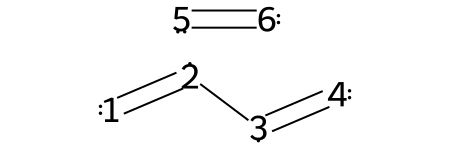

In [46]:
'''
Here is to show that for rdkit it can consider a number of molecules into one mol object
'''
y = Chem.MolFromSmiles('[C:1]=[C:2][C:3]=[C:4].[C:5]=[C:6]')
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
def show_atom_number(mol, label):
    for atom in mol.GetAtoms():
        atom.SetProp(label, str(atom.GetIdx()+1))
    return mol
y.GetNumAtoms()
show_atom_number(y, 'atomLabel')

In [47]:

class BatchMolGraph:
    """
    A :class:`BatchMolGraph` represents the graph structure and featurization of a batch of molecules.
    A BatchMolGraph contains the attributes of a :class:`MolGraph` plus:
    * :code:`atom_fdim`: The dimensionality of the atom feature vector.
    * :code:`bond_fdim`: The dimensionality of the bond feature vector (technically the combined atom/bond features).
    * :code:`a_scope`: A list of tuples indicating the start and end atom indices for each molecule.
    * :code:`b_scope`: A list of tuples indicating the start and end bond indices for each molecule.
    * :code:`max_num_bonds`: The maximum number of bonds neighboring an atom in this batch.
    * :code:`b2b`: (Optional) A mapping from a bond index to incoming bond indices.
    * :code:`a2a`: (Optional): A mapping from an atom index to neighboring atom indices.
    """

    def __init__(self, mol_graphs: List[MolGraph]):
        """
        :param mol_graphs: A list of :class:`MolGraph`s from which to construct the :class:`BatchMolGraph`.
        """
        self.overwrite_default_atom_features = mol_graphs[0].overwrite_default_atom_features
        self.overwrite_default_bond_features = mol_graphs[0].overwrite_default_bond_features
        self.is_reaction = mol_graphs[0].is_reaction
        self.atom_fdim = get_atom_fdim(overwrite_default_atom=self.overwrite_default_atom_features,
                                       is_reaction=self.is_reaction)
        self.bond_fdim = get_bond_fdim(overwrite_default_bond=self.overwrite_default_bond_features,
                                      overwrite_default_atom=self.overwrite_default_atom_features,
                                      is_reaction=self.is_reaction)

        # Start n_atoms and n_bonds at 1 b/c zero padding
        self.n_atoms = 1  # number of atoms (start at 1 b/c need index 0 as padding)
        self.n_bonds = 1  # number of bonds (start at 1 b/c need index 0 as padding)
        self.a_scope = []  # list of tuples indicating (start_atom_index, num_atoms) for each molecule
        self.b_scope = []  # list of tuples indicating (start_bond_index, num_bonds) for each molecule

        # All start with zero padding so that indexing with zero padding returns zeros
        f_atoms = [[0] * self.atom_fdim]  # atom features
        f_bonds = [[0] * self.bond_fdim]  # combined atom/bond features
        a2b = [[]]  # mapping from atom index to incoming bond indices
        b2a = [0]  # mapping from bond index to the index of the atom the bond is coming from
        b2revb = [0]  # mapping from bond index to the index of the reverse bond
        for mol_graph in mol_graphs:
            '''
            extend will make the list of features of a single molecule
            to be a list of features of a batch of molecule. It is like the 
            concate operation of graph class in deepchem
            '''
            f_atoms.extend(mol_graph.f_atoms)
            f_bonds.extend(mol_graph.f_bonds)
            '''
            It will add in the number of bonds of all molecules have been 
            visited. 
            a2b is in the form [[],[],[]....]
            need add the number of bonds is because the row of the bond is 
            changing by the extend operation used before
            '''
            for a in range(mol_graph.n_atoms):

                a2b.append([b + self.n_bonds for b in mol_graph.a2b[a]])

            for b in range(mol_graph.n_bonds):
                b2a.append(self.n_atoms + mol_graph.b2a[b])
                b2revb.append(self.n_bonds + mol_graph.b2revb[b])
            '''
            The scope will record where the accumulated number of atoms 
            and bonds comes from.
            '''
            self.a_scope.append((self.n_atoms, mol_graph.n_atoms))
            self.b_scope.append((self.n_bonds, mol_graph.n_bonds))
            self.n_atoms += mol_graph.n_atoms
            self.n_bonds += mol_graph.n_bonds
        '''
        Record max number of in coming bonds 
        '''
        self.max_num_bonds = max(1, max(
            len(in_bonds) for in_bonds in a2b))  # max with 1 to fix a crash in rare case of all single-heavy-atom mols

        self.f_atoms = torch.FloatTensor(f_atoms)
        self.f_bonds = torch.FloatTensor(f_bonds)
        '''
        It is trying to make sure the number of bond is the same for every atom
        the padding bond will be referred to the row 0 bond.
        '''
        self.a2b = torch.LongTensor([a2b[a] + [0] * (self.max_num_bonds - len(a2b[a])) for a in range(self.n_atoms)])
        self.b2a = torch.LongTensor(b2a)
        self.b2revb = torch.LongTensor(b2revb)
        self.b2b = None  # try to avoid computing b2b b/c O(n_atoms^3)
        self.a2a = None  # only needed if using atom messages

    def get_components(self, atom_messages: bool = False) -> Tuple[torch.FloatTensor, torch.FloatTensor,
                                                                   torch.LongTensor, torch.LongTensor, torch.LongTensor,
                                                                   List[Tuple[int, int]], List[Tuple[int, int]]]:
        """
        Returns the components of the :class:`BatchMolGraph`.
        The returned components are, in order:
        * :code:`f_atoms`
        * :code:`f_bonds`
        * :code:`a2b`
        * :code:`b2a`
        * :code:`b2revb`
        * :code:`a_scope`
        * :code:`b_scope`
        :param atom_messages: Whether to use atom messages instead of bond messages. This changes the bond feature
                              vector to contain only bond features rather than both atom and bond features.
        :return: A tuple containing PyTorch tensors with the atom features, bond features, graph structure,
                 and scope of the atoms and bonds (i.e., the indices of the molecules they belong to).
        """
        if atom_messages:
            f_bonds = self.f_bonds[:, -get_bond_fdim(atom_messages=atom_messages,
                                                     overwrite_default_atom=self.overwrite_default_atom_features,
                                                     overwrite_default_bond=self.overwrite_default_bond_features):]
        else:
            f_bonds = self.f_bonds

        return self.f_atoms, f_bonds, self.a2b, self.b2a, self.b2revb, self.a_scope, self.b_scope

    def get_b2b(self) -> torch.LongTensor:
        """
        Computes (if necessary) and returns a mapping from each bond index to all the incoming bond indices.
        :return: A PyTorch tensor containing the mapping from each bond index to all the incoming bond indices.
        """
        if self.b2b is None:
            b2b = self.a2b[self.b2a]  # num_bonds x max_num_bonds
            # b2b includes reverse edge for each bond so need to mask out
            revmask = (b2b != self.b2revb.unsqueeze(1).repeat(1, b2b.size(1))).long()  # num_bonds x max_num_bonds
            self.b2b = b2b * revmask

        return self.b2b

    def get_a2a(self) -> torch.LongTensor:
        """
        Computes (if necessary) and returns a mapping from each atom index to all neighboring atom indices.
        :return: A PyTorch tensor containing the mapping from each atom index to all the neighboring atom indices.
        """
        if self.a2a is None:
            # b = a1 --> a2
            # a2b maps a2 to all incoming bonds b
            # b2a maps each bond b to the atom it comes from a1
            # thus b2a[a2b] maps atom a2 to neighboring atoms a1
            self.a2a = self.b2a[self.a2b]  # num_atoms x max_num_bonds

        return self.a2a

smiles = ["C1CCC1", "C1=CC=CN=C1"]
Mols = [Chem.MolFromSmiles(i) for i in smiles]
mol_graph_list = [MolGraph(mol) for mol in Mols]
batch_graph = BatchMolGraph(mol_graph_list)
a2a = batch_graph.get_a2a
print(a2a)

<bound method BatchMolGraph.get_a2a of <__main__.BatchMolGraph object at 0x7fea841d6a30>>


The difference between the deepchem implementation and the chemprop implementation is mainly about the way to describe topology. DeepChem describe the topology from an atom point of view. It records which atom is connecting with which atom. As a result, the information will be mainly exchanged between nodes from a node point of view. However, for chemprop, messages are associated with directed edges instead of vertices, in contrast to deepchem. Thus it will try to record for each atom what are the bonds connected to it, and most of features will be aggregate on the edges as shown in the implementation. More details can be seen in the forward prediction part.